<a href="https://colab.research.google.com/github/BalthazazarDuc/MasterThesis/blob/main/Copie_de_MasterThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [180]:
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import numpy as np
import random
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [181]:
#GO_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/GO-Prices_Aggregated_v02%20.csv", sep=";", decimal = ",")
carbon_intensity = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/carbon-intensity-electricity.csv")
CI_PV = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/carbon_intensity_rooftop.csv")
LCOE = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/LCOE%202020.csv", sep=";")
solar_yield = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/solar_yield.csv")
E_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/data/european_wholesale_electricity_price_data_monthly.csv")

##Data cleaning

###carbon_intensity

In [182]:
# Step 1: Use the English country names from the dictionary
english_country_names = E_price['Country'].unique().tolist()
# Step 2: Filter the carbon_intensity DataFrame
carbon_intensity = carbon_intensity[carbon_intensity['Entity'].isin(english_country_names)]
carbon_intensity = carbon_intensity.rename(columns={'Entity': 'Country'})
carbon_intensity

,Country,Code,Year,Carbon intensity of electricity - gCO2/kWh
350,Austria,AUT,1990,249.84778
351,Austria,AUT,1991,262.75920
352,Austria,AUT,1992,201.64363
353,Austria,AUT,1993,183.58994
354,Austria,AUT,1994,196.15013
...,...,...,...,...
5540,United Kingdom,GBR,2019,265.21350
5541,United Kingdom,GBR,2020,243.57414
5542,United Kingdom,GBR,2021,268.55660
5543,United Kingdom,GBR,2022,255.84961


In [183]:
E_price = E_price.rename(columns={'ISO3 Code': 'Code'})
E_price.head(50)


,Country,Code,Date,Price (EUR/MWhe)
0,Austria,AUT,2015-01-01,29.94
1,Belgium,BEL,2015-01-01,42.33
2,Czechia,CZE,2015-01-01,29.47
3,Denmark,DNK,2015-01-01,27.12
4,Estonia,EST,2015-01-01,33.84
5,Finland,FIN,2015-01-01,33.81
6,France,FRA,2015-01-01,40.94
7,Germany,DEU,2015-01-01,29.94
8,Greece,GRC,2015-01-01,61.41
9,Hungary,HUN,2015-01-01,42.16


###Electrcity price

In [184]:
# Step 1: Convert 'Date' to datetime format
E_price['Date'] = pd.to_datetime(E_price['Date'])

# Step 2: Extract year into a new column
E_price['Year'] = E_price['Date'].dt.year

# Step 3: Group by Country and Year, and calculate mean price
yearly_price = E_price.groupby(['Country', 'Year', 'Code'])['Price (EUR/MWhe)'].mean().reset_index()
yearly_price

,Country,Year,Code,Price (EUR/MWhe)
0,Austria,2015,AUT,31.764167
1,Austria,2016,AUT,28.956667
2,Austria,2017,AUT,34.419167
3,Austria,2018,AUT,40.891667
4,Austria,2019,AUT,40.137500
...,...,...,...,...
324,United Kingdom,2021,GBR,136.991667
325,United Kingdom,2022,GBR,239.865000
326,United Kingdom,2023,GBR,108.526667
327,United Kingdom,2024,GBR,85.785833


###Carbon Intensity Solar




In [185]:
CI_PV.head()

,Country,Country code,Capital,CI electricity mix (gCO2-eq/kWh),S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh)
0,Austria,AT,"Vienna (48.2°N, 16.4°E)",264,35.1,42.0,50.2,72.2,211.0
1,Belgium,BE,"Brussels (50.8°N, 4.4°E)",230,40.1,47.9,56.0,80.8,206.9
2,Bulgaria,BG,"Sofia (42.6°N, 24°E)",544,30.8,37.4,48.1,69.9,190.6
3,Cyprus,CY,"Nicosia (35.1°N, 33.2°E)",791,25.5,28.9,41.8,55.1,192.0
4,Czechia,CZ,"Prague (50°N, 14.5°E)",564,38.3,45.5,54.4,78.1,214.8


In [186]:
def extract_latitude_from_capital(capital_string):
    if pd.isna(capital_string):
        return None

    try:
        # Print first few for debugging
        print(f"Processing: {capital_string}")

        # Try different patterns
        patterns = [
            r'(\d+\.?\d*)°N',           # 48.2°N
            r'(\d+\.?\d*)\s*°\s*N',     # 48.2 ° N
            r'(\d+\.?\d*)\s*N',         # 48.2 N
            r'(\d+\.?\d*),\s*\d+\.?\d*', # 48.2, 16.4 (assuming lat, lon)
        ]

        for pattern in patterns:
            lat_match = re.search(pattern, str(capital_string))
            if lat_match:
                latitude = float(lat_match.group(1))
                print(f"  → Found latitude: {latitude}")
                return latitude

        print(f"  → No latitude found")
        return None

    except Exception as e:
        print(f"  → Error: {e}")
        return None

In [187]:
CI_PV['Latitude'] = CI_PV['Capital'].apply(extract_latitude_from_capital)


Processing: Vienna (48.2°N, 16.4°E)
  → Found latitude: 48.2
Processing: Brussels (50.8°N, 4.4°E)
  → Found latitude: 50.8
Processing: Sofia (42.6°N, 24°E)
  → Found latitude: 42.6
Processing: Nicosia (35.1°N, 33.2°E)
  → Found latitude: 35.1
Processing: Prague (50°N, 14.5°E)
  → Found latitude: 50.0
Processing: Berlin (52.5°N, 13.4°E)
  → Found latitude: 52.5
Processing: Copenhagen (55.7°N, 12.6°E)
  → Found latitude: 55.7
Processing: Tallinn (59.4°N, 24.8°E)
  → Found latitude: 59.4
Processing: Athens (38°N, 23.7°E)
  → Found latitude: 38.0
Processing: Madrid (40.4°N, 3.7°W)
  → Found latitude: 40.4
Processing: Helsinki (60.2°N, 24.9°E)
  → Found latitude: 60.2
Processing: Paris (48.9°N, 2.3°E)
  → Found latitude: 48.9
Processing: Zagreb (45.8°N, 16°E)
  → Found latitude: 45.8
Processing: Budapest (47.5°N, 19.1°E)
  → Found latitude: 47.5
Processing: Dublin (53.3°N, 6.3°E)
  → Found latitude: 53.3
Processing: Rome (41.9°N, 12.5°E)
  → Found latitude: 41.9
Processing: Riga (56.9°N, 24

In [188]:
#GO_price['Land'].unique()
CI_PV = CI_PV.drop(columns=['Country code', 'CI electricity mix (gCO2-eq/kWh)', 'Capital'])
CI_PV.head()


,Country,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,35.1,42.0,50.2,72.2,211.0,48.2
1,Belgium,40.1,47.9,56.0,80.8,206.9,50.8
2,Bulgaria,30.8,37.4,48.1,69.9,190.6,42.6
3,Cyprus,25.5,28.9,41.8,55.1,192.0,35.1
4,Czechia,38.3,45.5,54.4,78.1,214.8,50.0


##Merging

In [189]:
df1 = pd.merge(yearly_price, carbon_intensity, on=['Country', 'Code', 'Year'], how='inner')
df2= pd.merge(LCOE, df1, on=['Country'], how='inner')
df3= pd.merge(solar_yield, df2, on=['Country'], how='inner')
df=pd.merge(df3, CI_PV, on=['Country'], how='inner')
df

,Country,S-opta insolation (kWh/m2·year),S-opta energy yield (kWh/kWp·year),LCOE,Year,Code,Price (EUR/MWhe),Carbon intensity of electricity - gCO2/kWh,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,1477.5,1179.9,"0,09",2015,AUT,31.764167,172.062160,35.1,42.0,50.2,72.2,211.0,48.2
1,Austria,1477.5,1179.9,"0,09",2016,AUT,28.956667,154.616910,35.1,42.0,50.2,72.2,211.0,48.2
2,Austria,1477.5,1179.9,"0,09",2017,AUT,34.419167,162.915500,35.1,42.0,50.2,72.2,211.0,48.2
3,Austria,1477.5,1179.9,"0,09",2018,AUT,40.891667,157.878460,35.1,42.0,50.2,72.2,211.0,48.2
4,Austria,1477.5,1179.9,"0,09",2019,AUT,40.137500,152.779740,35.1,42.0,50.2,72.2,211.0,48.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Switzerland,1502.3,1195.5,"0,09",2019,CHE,40.951667,33.867085,34.7,41.3,49.4,73.1,205.2,46.9
233,Switzerland,1502.3,1195.5,"0,09",2020,CHE,33.988333,35.041615,34.7,41.3,49.4,73.1,205.2,46.9
234,Switzerland,1502.3,1195.5,"0,09",2021,CHE,114.569167,37.083992,34.7,41.3,49.4,73.1,205.2,46.9
235,Switzerland,1502.3,1195.5,"0,09",2022,CHE,280.995833,36.132970,34.7,41.3,49.4,73.1,205.2,46.9


In [190]:
df.columns

Index(['Country', 'S-opta insolation (kWh/m2·year)',
       'S-opta energy yield (kWh/kWp·year)', 'LCOE', 'Year', 'Code',
       'Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
       'S-opta (gCO2-eq/kWh)', 'Flat roof (gCO2-eq/kWh)',
       'S-90° (gCO2-eq/kWh)', 'W-90° (gCO2-eq/kWh)', 'N-90° (gCO2-eq/kWh)',
       'Latitude'],
      dtype='object')

In [191]:
new_order = [
    "Country",
    "Year",
    'Latitude',
    "Carbon intensity of electricity - gCO2/kWh",
    "Code",
    "Price (EUR/MWhe)",
    "LCOE",
    "S-opta insolation (kWh/m2·year)",
    "S-opta energy yield (kWh/kWp·year)",
    "S-opta (gCO2-eq/kWh)",
    "Flat roof (gCO2-eq/kWh)",
    "S-90° (gCO2-eq/kWh)",
    "W-90° (gCO2-eq/kWh)",
    "N-90° (gCO2-eq/kWh)"
]

df = df[new_order]

df['LCOE'] = df['LCOE'].str.replace(',', '.').astype(float)

In [192]:
df


,Country,Year,Latitude,Carbon intensity of electricity - gCO2/kWh,Code,Price (EUR/MWhe),LCOE,S-opta insolation (kWh/m2·year),S-opta energy yield (kWh/kWp·year),S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh)
0,Austria,2015,48.2,172.062160,AUT,31.764167,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0
1,Austria,2016,48.2,154.616910,AUT,28.956667,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0
2,Austria,2017,48.2,162.915500,AUT,34.419167,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0
3,Austria,2018,48.2,157.878460,AUT,40.891667,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0
4,Austria,2019,48.2,152.779740,AUT,40.137500,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Switzerland,2019,46.9,33.867085,CHE,40.951667,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2
233,Switzerland,2020,46.9,35.041615,CHE,33.988333,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2
234,Switzerland,2021,46.9,37.083992,CHE,114.569167,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2
235,Switzerland,2022,46.9,36.132970,CHE,280.995833,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2


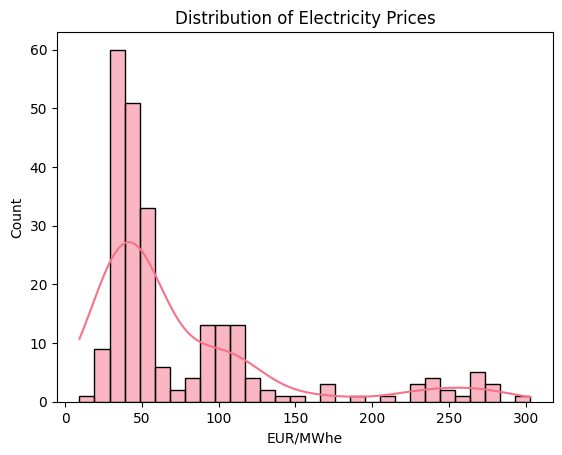

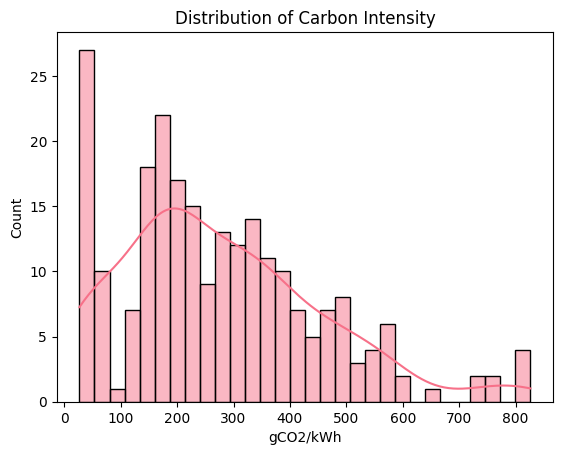

In [193]:
sns.histplot(df['Price (EUR/MWhe)'], bins=30, kde=True)
plt.title('Distribution of Electricity Prices')
plt.xlabel('EUR/MWhe')
plt.show()

# Carbon intensity distribution
sns.histplot(df['Carbon intensity of electricity - gCO2/kWh'], bins=30, kde=True)
plt.title('Distribution of Carbon Intensity')
plt.xlabel('gCO2/kWh')
plt.show()


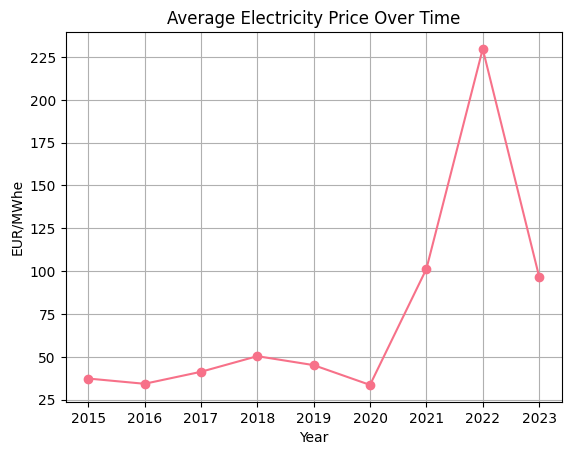

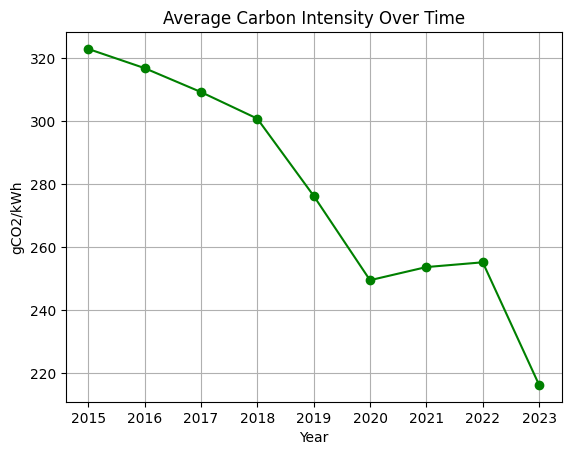

In [194]:
# Average price over years
df.groupby('Year')['Price (EUR/MWhe)'].mean().plot(marker='o')
plt.title('Average Electricity Price Over Time')
plt.ylabel('EUR/MWhe')
plt.grid(True)
plt.show()

# Average carbon intensity over years
df.groupby('Year')['Carbon intensity of electricity - gCO2/kWh'].mean().plot(marker='o', color='green')
plt.title('Average Carbon Intensity Over Time')
plt.ylabel('gCO2/kWh')
plt.grid(True)
plt.show()


#Multiple year cluster analysis

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def cluster_countries_multi_year(df, n_clusters=4):
    """
    Cluster countries based on multi-year averages of:
    - Electricity Price (time series, averaged 2015-2023)
    - Grid Carbon Intensity (time series, averaged 2015-2023)
    - PV Energy Yield (constant per country)
    """
    print("🌍 MULTI-YEAR CLUSTERING (2015-2023)")
    print("="*60)

    # Define years
    years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
    print(f"Years included: {years[0]}-{years[-1]}")

    # Filter for selected years
    df_years = df[df['Year'].isin(years)].copy()

    # Calculate country averages
    country_features = []

    for country in df_years['Country'].unique():
        country_data = df_years[df_years['Country'] == country]

        # Skip if insufficient data
        if len(country_data) < 3:  # Require at least 3 years
            print(f"⚠️  Skipping {country}: Only {len(country_data)} years of data")
            continue

        # Get 2023 data for summary (if available)
        data_2023 = country_data[country_data['Year'] == 2023]

        # Calculate features (clustering uses multi-year averages)
        features = {
            'Country': country,
            'Avg_Price': country_data['Price (EUR/MWhe)'].mean(),
            'Avg_Grid_CI': country_data['Carbon intensity of electricity - gCO2/kWh'].mean(),
            'PV_Energy_Yield': country_data['S-opta energy yield (kWh/kWp·year)'].iloc[0],  # Constant per country
            'Price_Std': country_data['Price (EUR/MWhe)'].std(),
            'Years_Data': len(country_data),
            # 2023 data for summary display
            'Price_2023': data_2023['Price (EUR/MWhe)'].iloc[0] if len(data_2023) > 0 else country_data['Price (EUR/MWhe)'].iloc[-1],
            'Grid_CI_2023': data_2023['Carbon intensity of electricity - gCO2/kWh'].iloc[0] if len(data_2023) > 0 else country_data['Carbon intensity of electricity - gCO2/kWh'].iloc[-1]
        }

        country_features.append(features)

    features_df = pd.DataFrame(country_features)
    print(f"\nCountries with sufficient data: {len(features_df)}")

    # Prepare features for clustering
    feature_cols = ['PV_Energy_Yield', 'Avg_Grid_CI', 'Avg_Price']
    X = features_df[feature_cols].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Test different k values if n_clusters='auto'
    if n_clusters == 'auto':
        scores = {}
        for k in range(2, 7):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            scores[k] = silhouette_score(X_scaled, labels)

        n_clusters = max(scores, key=scores.get)
        print(f"\nOptimal clusters: {n_clusters} (silhouette: {scores[n_clusters]:.3f})")

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)
    features_df['Cluster'] = clusters

    # Print cluster summary
    print("\n" + "="*60)
    print("CLUSTER RESULTS (2023 Data)")
    print("="*60)

    for cluster in range(n_clusters):
        cluster_data = features_df[features_df['Cluster'] == cluster]
        countries = sorted(cluster_data['Country'].tolist())

        print(f"\nCluster {cluster} ({len(countries)} countries):")
        print(f"  Countries: {', '.join(countries)}")
        print(f"  2023 Averages:")
        print(f"    • Price: {cluster_data['Price_2023'].mean():.1f} EUR/MWh")
        print(f"    • Grid CI: {cluster_data['Grid_CI_2023'].mean():.0f} gCO2/kWh")
        print(f"    • PV Energy Yield: {cluster_data['PV_Energy_Yield'].mean():.0f} kWh/kWp·year")

    # Create visualizations
    create_visualizations(features_df, n_clusters)

    # Update original dataframe
    country_cluster_map = dict(zip(features_df['Country'], features_df['Cluster']))
    df['Cluster'] = df['Country'].map(country_cluster_map)

    print(f"\n✅ Clustering complete!")

    return df, features_df

def create_visualizations(df, n_clusters):
    """
    Create visualization plots for the clusters
    """
    # Define cluster names mapping
    cluster_names = {
        0: "Iberian",
        1: "Eastern_Europe",
        2: "Central_Europe",
        3: "Mixed_european",
        4: "Southern",
        5: "Nordic"
    }

    colors = sns.color_palette('husl', n_clusters)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: PV Energy Yield vs Grid CI
    ax1 = axes[0, 0]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
        ax1.scatter(cluster_data['PV_Energy_Yield'], cluster_data['Avg_Grid_CI'],
                   c=[colors[cluster]], label=cluster_name, s=100, alpha=0.7)

    ax1.set_xlabel('PV Energy Yield (kWh/kWp·year)')
    ax1.set_ylabel('Avg Grid CI (gCO2/kWh)')
    ax1.set_title('PV Energy Yield vs Carbon Intensity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Grid CI vs Price with country labels
    ax2 = axes[0, 1]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
        ax2.scatter(cluster_data['Avg_Grid_CI'], cluster_data['Avg_Price'],
                   c=[colors[cluster]], label=cluster_name, s=100, alpha=0.7)

        # Add country labels
        for _, row in cluster_data.iterrows():
            ax2.annotate(row['Country'], (row['Avg_Grid_CI'], row['Avg_Price']),
                        xytext=(3, 3), textcoords='offset points', fontsize=7)

    ax2.set_xlabel('Avg Grid CI (gCO2/kWh)')
    ax2.set_ylabel('Avg Price (EUR/MWh)')
    ax2.set_title('Carbon Intensity vs Electricity Price')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Cluster sizes
    ax3 = axes[1, 0]
    cluster_sizes = df['Cluster'].value_counts().sort_index()
    bars = ax3.bar(range(n_clusters), cluster_sizes.values, color=colors, alpha=0.7)

    for bar, size, cluster in zip(bars, cluster_sizes.values, range(n_clusters)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(size), ha='center', va='bottom')

    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Number of Countries')
    ax3.set_title('Countries per Cluster')
    # Update x-tick labels to show cluster names
    ax3.set_xticks(range(n_clusters))
    ax3.set_xticklabels([cluster_names.get(i, f'Cluster {i}') for i in range(n_clusters)],
                        rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Feature comparison
    ax4 = axes[1, 1]

    # Normalize features for comparison
    features = ['Avg_Price', 'Avg_Grid_CI', 'PV_Energy_Yield']
    cluster_means = df.groupby('Cluster')[features].mean()

    # Create grouped bar chart
    x = np.arange(len(features))
    width = 0.8 / n_clusters

    for i in range(n_clusters):
        # Normalize values to percentage of maximum
        values = cluster_means.iloc[i] / df[features].max() * 100
        cluster_name = cluster_names.get(i, f'Cluster {i}')
        ax4.bar(x + i * width, values, width,
                label=cluster_name, color=colors[i], alpha=0.7)

    ax4.set_xlabel('Features')
    ax4.set_ylabel('% of Maximum')
    ax4.set_title('Normalized Feature Comparison')
    ax4.set_xticks(x + width * (n_clusters - 1) / 2)
    ax4.set_xticklabels(['Price', 'Grid CI', 'PV Yield'])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Simple usage function
def run_clustering(df):
    """
    Simple wrapper to run the clustering with default settings

    Data handling approach:
    - Electricity Price: Time series, uses multi-year average (2015-2023) for clustering
    - Grid Carbon Intensity: Time series, uses multi-year average (2015-2023) for clustering
    - PV Energy Yield: Constant per country, uses single value for clustering
    - Summary displays 2023 data (or latest available) for interpretability
    """
    # Run with 6 clusters by default, or use 'auto' to find optimal
    return cluster_countries_multi_year(df, n_clusters=6)

# Example usage:
# df, results = run_clustering(df)
# Or specify clusters:
# df, results = cluster_countries_multi_year(df, n_clusters=5)
# Or find optimal:
# df, results = cluster_countries_multi_year(df, n_clusters='auto')

🌍 MULTI-YEAR CLUSTERING (2015-2023)
Years included: 2015-2023

Countries with sufficient data: 27

Optimal clusters: 6 (silhouette: 0.431)

CLUSTER RESULTS (2023 Data)

Cluster 0 (2 countries):
  Countries: Portugal, Spain
  2023 Averages:
    • Price: 88.0 EUR/MWh
    • Grid CI: 170 gCO2/kWh
    • PV Energy Yield: 1606 kWh/kWp·year

Cluster 1 (9 countries):
  Countries: Austria, Belgium, Denmark, France, Latvia, Lithuania, Luxembourg, Slovakia, Switzerland
  2023 Averages:
    • Price: 97.7 EUR/MWh
    • Grid CI: 111 gCO2/kWh
    • PV Energy Yield: 1087 kWh/kWp·year

Cluster 2 (5 countries):
  Countries: Czechia, Estonia, Germany, Netherlands, Poland
  2023 Averages:
    • Price: 99.1 EUR/MWh
    • Grid CI: 435 gCO2/kWh
    • PV Energy Yield: 1026 kWh/kWp·year

Cluster 3 (5 countries):
  Countries: Croatia, Hungary, Ireland, Romania, Slovenia
  2023 Averages:
    • Price: 109.2 EUR/MWh
    • Grid CI: 234 gCO2/kWh
    • PV Energy Yield: 1167 kWh/kWp·year

Cluster 4 (3 countries):
  Cou

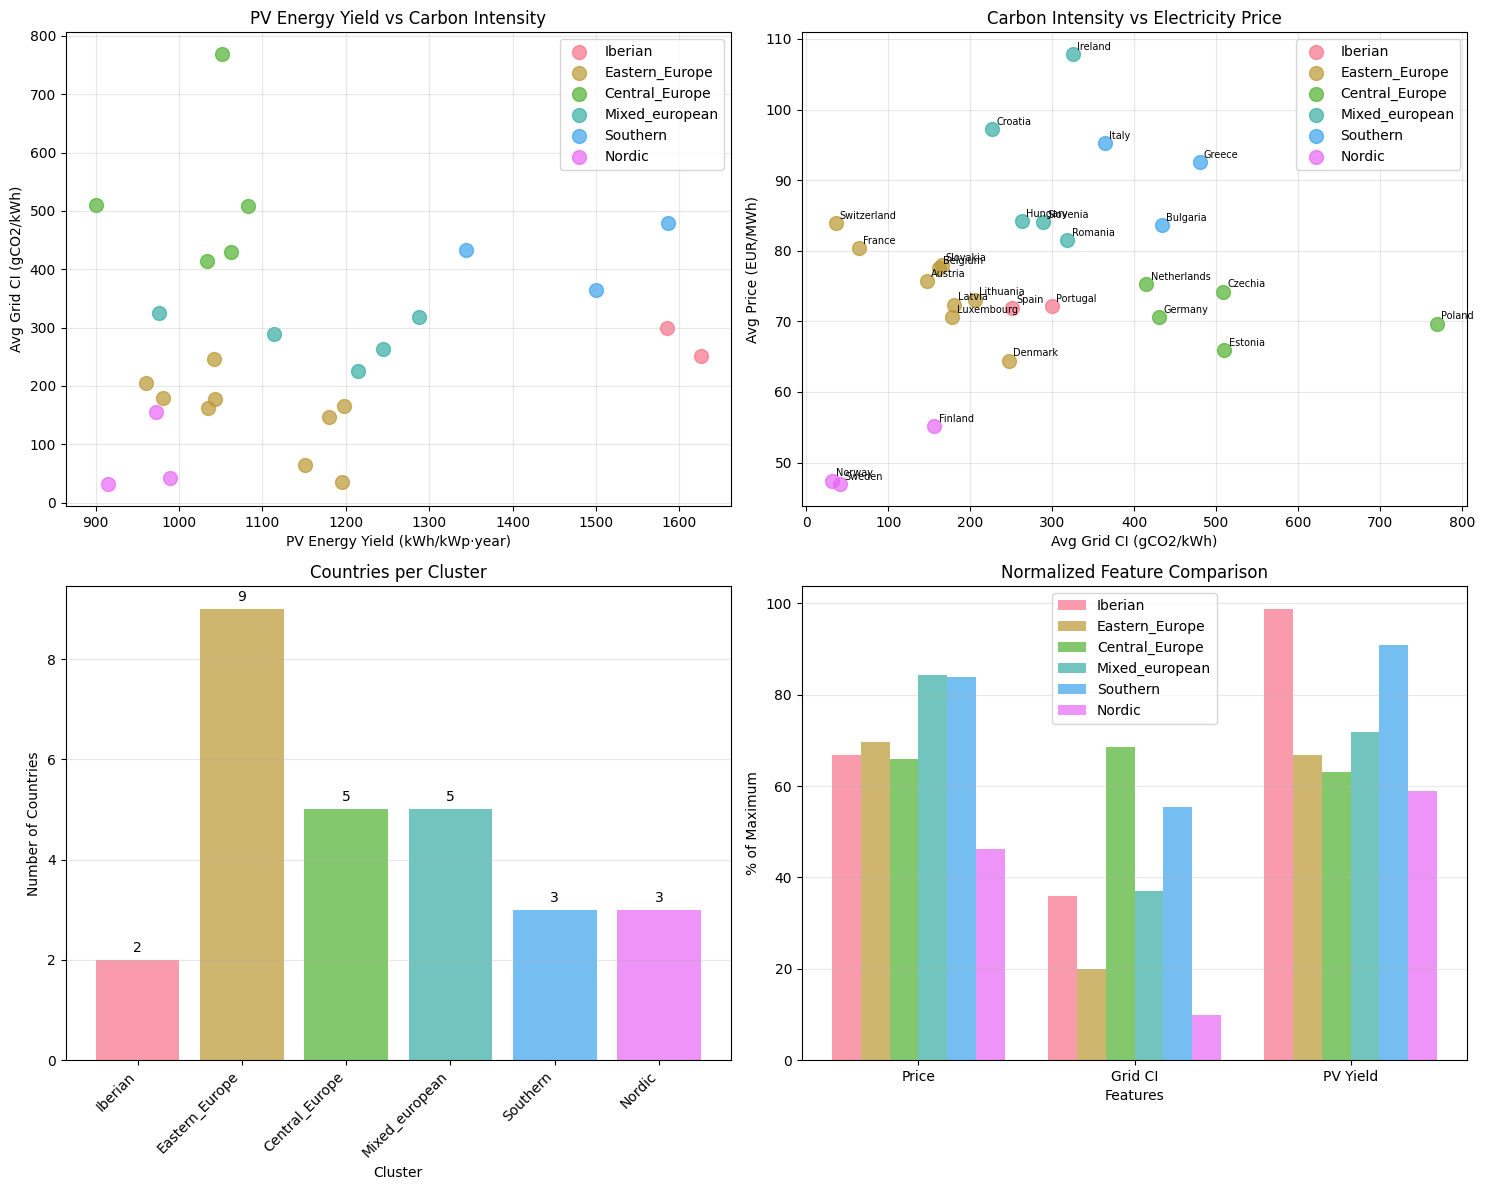


✅ Clustering complete!


In [218]:
# Example usage:
#df, results = run_clustering(df)
# Or specify clusters:
#df, results = cluster_countries_multi_year(df, n_clusters=6)
# Or find optimal:
df, results = cluster_countries_multi_year(df, n_clusters='auto')

In [212]:
cluster_map = {
0: "Iberian",
1: "Central_Europe_Low_CI",
2: "Central_Europe_High_CI",
3: "Mixed_european",
4: "Southern",
5: "Nordic"
}

    # Create the new column
df["Cluster_Name"] = df["Cluster"].map(cluster_map)

In [165]:
 #Get unique country-cluster mapping
country_data = df.groupby('Country').agg({
    'Cluster_Name': 'first',
    'Code': 'first'
}).reset_index()

# Define colors to match your actual cluster names
cluster_colors = {
    'Iberian': '#C73E1D',          # Red
    'Central_Europe_High_CI': '#F18F01',   # Orange
    "Central_Europe_Low_CI": '#A23B72',   # Purple
    'Mixed_european': '#048A81',   # Teal
    'Southern': '#592E83',         # Dark Purple
    'Nordic': '#2E86AB'            # Blue
}

# Create the map
fig = px.choropleth(
    country_data,
    locations='Code',
    color='Cluster_Name',
    hover_name='Country',
    hover_data={'Cluster_Name': True, 'Code': False},
    color_discrete_map=cluster_colors,
    title='European Electricity Market Clusters',
    scope='europe'
)

# Customize the map
fig.update_layout(
    title={
        'text': 'European Electricity Market Clusters',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': 'black'}
    },
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    width=1000,
    height=700
)

# Show the map
fig.show()

#Economical analysis

In [61]:
df

,Country,S-opta insolation (kWh/m2·year),S-opta energy yield (kWh/kWp·year),LCOE,Year,Code,Price (EUR/MWhe),Carbon intensity of electricity - gCO2/kWh,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude,Cluster,Cluster_Name
0,Austria,1477.5,1179.9,"0,09",2015,AUT,31.764167,172.062160,35.1,42.0,50.2,72.2,211.0,48.2,0.0,Nordic
1,Austria,1477.5,1179.9,"0,09",2016,AUT,28.956667,154.616910,35.1,42.0,50.2,72.2,211.0,48.2,0.0,Nordic
2,Austria,1477.5,1179.9,"0,09",2017,AUT,34.419167,162.915500,35.1,42.0,50.2,72.2,211.0,48.2,0.0,Nordic
3,Austria,1477.5,1179.9,"0,09",2018,AUT,40.891667,157.878460,35.1,42.0,50.2,72.2,211.0,48.2,0.0,Nordic
4,Austria,1477.5,1179.9,"0,09",2019,AUT,40.137500,152.779740,35.1,42.0,50.2,72.2,211.0,48.2,0.0,Nordic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Switzerland,1502.3,1195.5,"0,09",2019,CHE,40.951667,33.867085,34.7,41.3,49.4,73.1,205.2,46.9,0.0,Nordic
233,Switzerland,1502.3,1195.5,"0,09",2020,CHE,33.988333,35.041615,34.7,41.3,49.4,73.1,205.2,46.9,0.0,Nordic
234,Switzerland,1502.3,1195.5,"0,09",2021,CHE,114.569167,37.083992,34.7,41.3,49.4,73.1,205.2,46.9,0.0,Nordic
235,Switzerland,1502.3,1195.5,"0,09",2022,CHE,280.995833,36.132970,34.7,41.3,49.4,73.1,205.2,46.9,0.0,Nordic


COMPREHENSIVE CLUSTER ANALYSIS

📊 CLUSTER OVERVIEW
--------------------------------------------------
Cluster 0: 2 countries, 18 records
Countries: Spain, Portugal

Cluster 1: 9 countries, 81 records
Countries: Austria, Belgium, Denmark, France, Latvia, Lithuania, Luxembourg, Slovakia, Switzerland

Cluster 2: 5 countries, 45 records
Countries: Czechia, Germany, Estonia, Netherlands, Poland

Cluster 3: 5 countries, 40 records
Countries: Croatia, Hungary, Ireland, Romania, Slovenia

Cluster 4: 3 countries, 26 records
Countries: Bulgaria, Greece, Italy

Cluster 5: 3 countries, 27 records
Countries: Finland, Sweden, Norway


📈 DETAILED CLUSTER STATISTICS

🏷️  CLUSTER 0
------------------------------------------------------------
Countries (2): Spain, Portugal
Data period: 2015-2023
Total records: 18

📊 Key Metrics Summary:
Metric                              Mean       Median     Min        Max        Std       
------------------------------------------------------------------------------

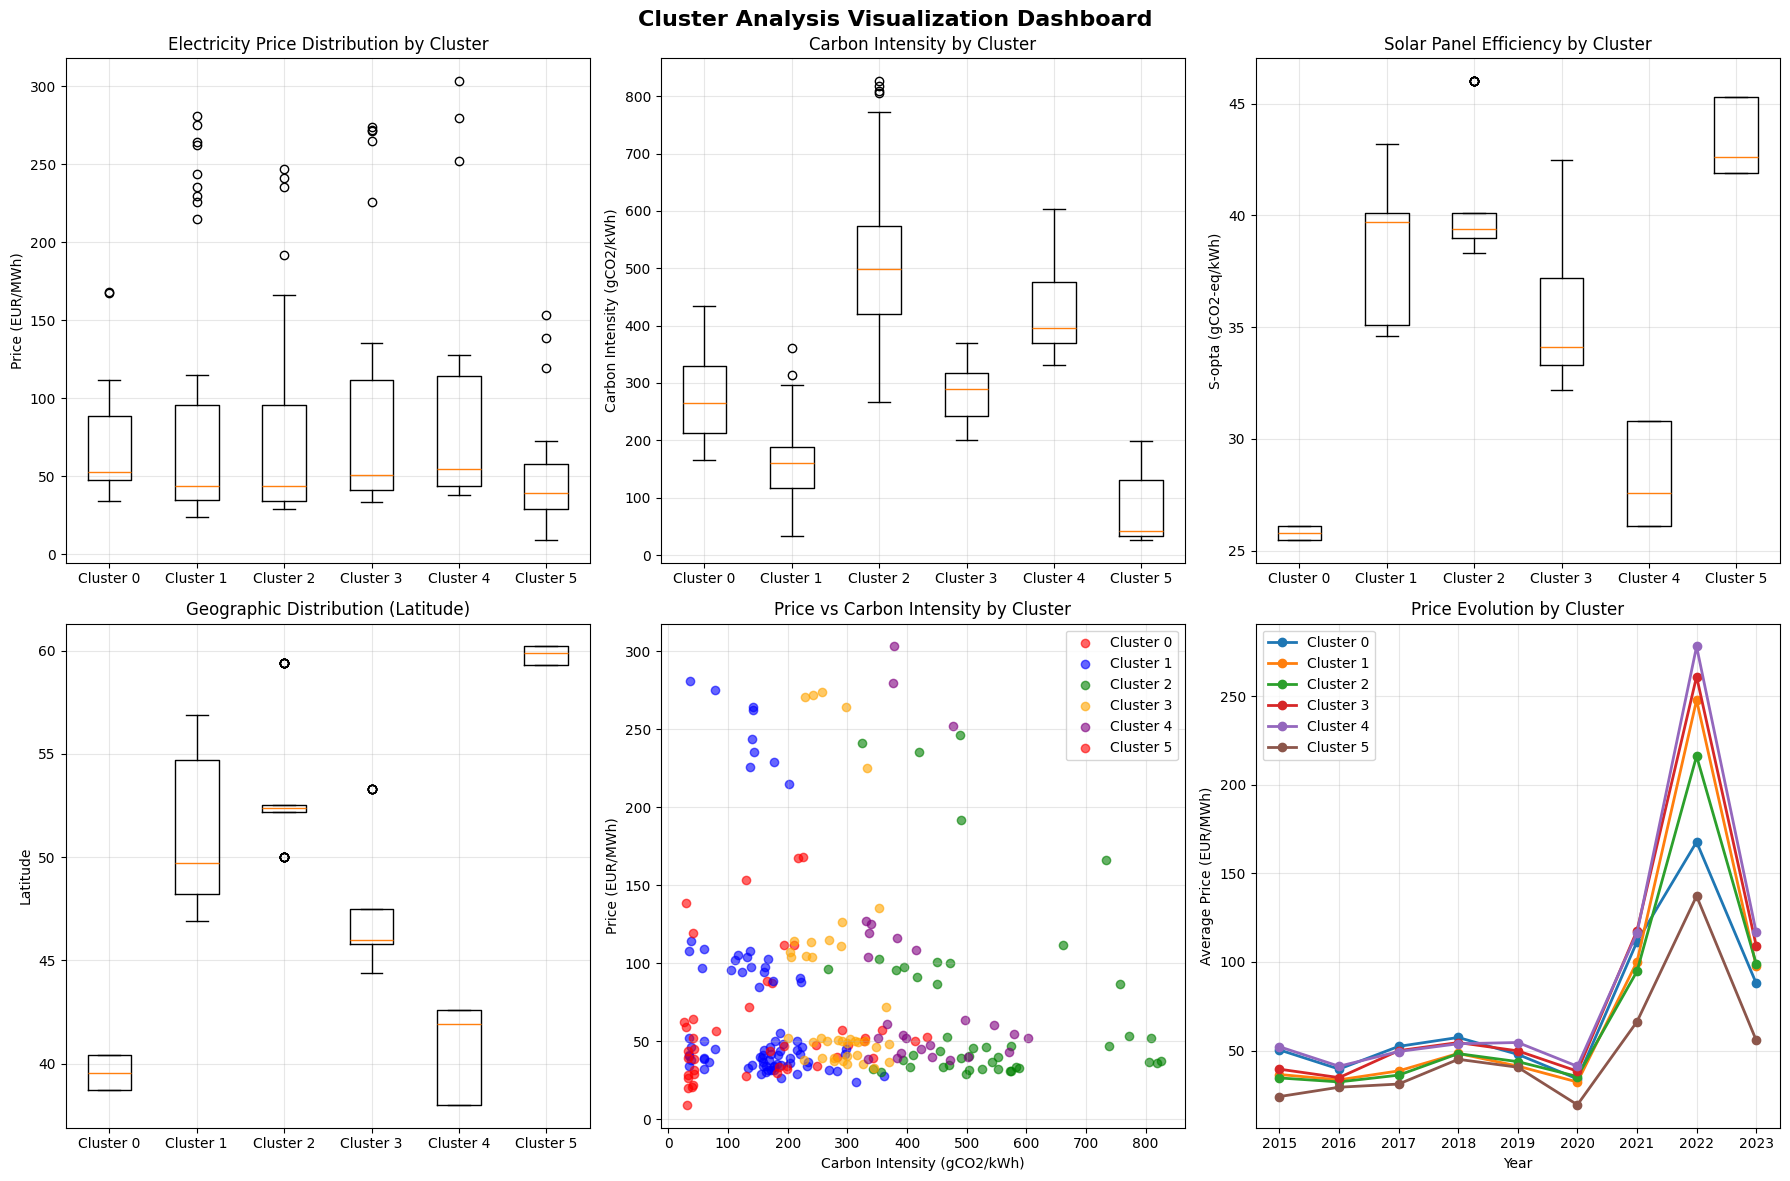


🔗 CLUSTER CORRELATION ANALYSIS

📊 Cluster 0 Internal Correlations:
                                            Price (EUR/MWhe)  \
Price (EUR/MWhe)                                       1.000   
Carbon intensity of electricity - gCO2/kWh            -0.482   
S-opta (gCO2-eq/kWh)                                   0.003   
Latitude                                              -0.003   

                                            Carbon intensity of electricity - gCO2/kWh  \
Price (EUR/MWhe)                                                                -0.482   
Carbon intensity of electricity - gCO2/kWh                                       1.000   
S-opta (gCO2-eq/kWh)                                                             0.313   
Latitude                                                                        -0.313   

                                            S-opta (gCO2-eq/kWh)  Latitude  
Price (EUR/MWhe)                                           0.003    -0.003  
Carbon

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_cluster_statistics(df):
    """
    Create comprehensive statistics for each cluster in the dataset
    """

    # Basic cluster overview
    print("=" * 80)
    print("COMPREHENSIVE CLUSTER ANALYSIS")
    print("=" * 80)

    # Cluster counts and countries
    print("\n📊 CLUSTER OVERVIEW")
    print("-" * 50)
    cluster_countries = df.groupby('Cluster')['Country'].unique()
    cluster_counts = df.groupby('Cluster').size()

    for cluster in sorted(df['Cluster'].unique()):
        countries = cluster_countries[cluster]
        count = cluster_counts[cluster]
        print(f"Cluster {cluster}: {len(countries)} countries, {count} records")
        print(f"Countries: {', '.join(countries)}")
        print()

    # Key variables for analysis
    numeric_vars = ['Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
                   'S-opta (gCO2-eq/kWh)', 'Flat roof (gCO2-eq/kWh)',
                   'S-90° (gCO2-eq/kWh)', 'W-90° (gCO2-eq/kWh)',
                   'N-90° (gCO2-eq/kWh)', 'Latitude']

    # Statistical summary by cluster
    print("\n📈 DETAILED CLUSTER STATISTICS")
    print("=" * 80)

    cluster_stats = {}

    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]

        print(f"\n🏷️  CLUSTER {cluster}")
        print("-" * 60)

        # Basic info
        countries = cluster_data['Country'].unique()
        years_range = f"{cluster_data['Year'].min()}-{cluster_data['Year'].max()}"

        print(f"Countries ({len(countries)}): {', '.join(countries)}")
        print(f"Data period: {years_range}")
        print(f"Total records: {len(cluster_data)}")

        # Statistical summary
        stats_summary = cluster_data[numeric_vars].describe()

        print(f"\n📊 Key Metrics Summary:")
        print(f"{'Metric':<35} {'Mean':<10} {'Median':<10} {'Min':<10} {'Max':<10} {'Std':<10}")
        print("-" * 85)

        for var in numeric_vars:
            if var in cluster_data.columns:
                mean_val = cluster_data[var].mean()
                median_val = cluster_data[var].median()
                min_val = cluster_data[var].min()
                max_val = cluster_data[var].max()
                std_val = cluster_data[var].std()

                print(f"{var:<35} {mean_val:<10.2f} {median_val:<10.2f} {min_val:<10.2f} {max_val:<10.2f} {std_val:<10.2f}")

        # Store for comparison
        cluster_stats[cluster] = {
            'countries': countries,
            'mean_price': cluster_data['Price (EUR/MWhe)'].mean(),
            'mean_carbon_intensity': cluster_data['Carbon intensity of electricity - gCO2/kWh'].mean(),
            'mean_s_opta': cluster_data['S-opta (gCO2-eq/kWh)'].mean(),
            'mean_latitude': cluster_data['Latitude'].mean(),
            'price_volatility': cluster_data['Price (EUR/MWhe)'].std(),
            'records': len(cluster_data)
        }

        print()

    # Cluster comparison
    print("\n🔍 CLUSTER COMPARISON MATRIX")
    print("=" * 80)

    comparison_df = pd.DataFrame(cluster_stats).T
    comparison_df = comparison_df.round(2)

    print("\nPrice Statistics (EUR/MWh):")
    print(f"{'Cluster':<10} {'Mean Price':<12} {'Volatility':<12} {'Countries':<30}")
    print("-" * 70)

    for cluster in sorted(cluster_stats.keys()):
        stats = cluster_stats[cluster]
        countries_str = ', '.join(stats['countries'][:3])  # Show first 3 countries
        if len(stats['countries']) > 3:
            countries_str += f" (+{len(stats['countries'])-3} more)"

        print(f"{cluster:<10} {stats['mean_price']:<12.2f} {stats['price_volatility']:<12.2f} {countries_str:<30}")

    print("\nEnvironmental Characteristics:")
    print(f"{'Cluster':<10} {'Carbon Int.':<12} {'Solar Eff.':<12} {'Latitude':<12}")
    print("-" * 50)

    for cluster in sorted(cluster_stats.keys()):
        stats = cluster_stats[cluster]
        print(f"{cluster:<10} {stats['mean_carbon_intensity']:<12.0f} {stats['mean_s_opta']:<12.1f} {stats['mean_latitude']:<12.1f}")

    return cluster_stats

def create_cluster_visualizations(df):
    """
    Create visualizations for cluster analysis
    """

    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cluster Analysis Visualization Dashboard', fontsize=16, fontweight='bold')

    # 1. Price distribution by cluster
    axes[0,0].boxplot([df[df['Cluster']==i]['Price (EUR/MWhe)'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,0].set_title('Electricity Price Distribution by Cluster')
    axes[0,0].set_ylabel('Price (EUR/MWh)')
    axes[0,0].grid(True, alpha=0.3)

    # 2. Carbon intensity by cluster
    axes[0,1].boxplot([df[df['Cluster']==i]['Carbon intensity of electricity - gCO2/kWh'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,1].set_title('Carbon Intensity by Cluster')
    axes[0,1].set_ylabel('Carbon Intensity (gCO2/kWh)')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Solar efficiency (S-opta) by cluster
    axes[0,2].boxplot([df[df['Cluster']==i]['S-opta (gCO2-eq/kWh)'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[0,2].set_title('Solar Panel Efficiency by Cluster')
    axes[0,2].set_ylabel('S-opta (gCO2-eq/kWh)')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Geographic distribution (Latitude)
    axes[1,0].boxplot([df[df['Cluster']==i]['Latitude'].values
                       for i in sorted(df['Cluster'].unique())],
                      labels=[f'Cluster {i}' for i in sorted(df['Cluster'].unique())])
    axes[1,0].set_title('Geographic Distribution (Latitude)')
    axes[1,0].set_ylabel('Latitude')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Price vs Carbon Intensity scatter
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, cluster in enumerate(sorted(df['Cluster'].unique())):
        cluster_data = df[df['Cluster'] == cluster]
        axes[1,1].scatter(cluster_data['Carbon intensity of electricity - gCO2/kWh'],
                         cluster_data['Price (EUR/MWhe)'],
                         c=colors[i % len(colors)],
                         label=f'Cluster {cluster}', alpha=0.6)

    axes[1,1].set_xlabel('Carbon Intensity (gCO2/kWh)')
    axes[1,1].set_ylabel('Price (EUR/MWh)')
    axes[1,1].set_title('Price vs Carbon Intensity by Cluster')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Time series of average price by cluster
    yearly_avg = df.groupby(['Year', 'Cluster'])['Price (EUR/MWhe)'].mean().reset_index()

    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = yearly_avg[yearly_avg['Cluster'] == cluster]
        axes[1,2].plot(cluster_data['Year'], cluster_data['Price (EUR/MWhe)'],
                      marker='o', label=f'Cluster {cluster}', linewidth=2)

    axes[1,2].set_xlabel('Year')
    axes[1,2].set_ylabel('Average Price (EUR/MWh)')
    axes[1,2].set_title('Price Evolution by Cluster')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

def cluster_correlation_analysis(df):
    """
    Analyze correlations within and between clusters
    """
    print("\n🔗 CLUSTER CORRELATION ANALYSIS")
    print("=" * 80)

    # Key variables for correlation
    key_vars = ['Price (EUR/MWhe)', 'Carbon intensity of electricity - gCO2/kWh',
               'S-opta (gCO2-eq/kWh)', 'Latitude']

    for cluster in sorted(df['Cluster'].unique()):
        print(f"\n📊 Cluster {cluster} Internal Correlations:")
        cluster_data = df[df['Cluster'] == cluster]
        corr_matrix = cluster_data[key_vars].corr()
        print(corr_matrix.round(3))

def investment_attractiveness_by_cluster(df):
    """
    Calculate investment attractiveness metrics by cluster
    """
    print("\n💰 INVESTMENT ATTRACTIVENESS BY CLUSTER")
    print("=" * 80)

    cluster_investment = df.groupby('Cluster').agg({
        'Price (EUR/MWhe)': ['mean', 'std', 'min', 'max'],
        'Carbon intensity of electricity - gCO2/kWh': 'mean',
        'S-opta (gCO2-eq/kWh)': 'mean',
        'Country': 'nunique'
    }).round(2)

    cluster_investment.columns = ['Avg_Price', 'Price_Volatility', 'Min_Price', 'Max_Price',
                                 'Avg_Carbon_Intensity', 'Avg_Solar_Efficiency', 'Num_Countries']

    # Calculate investment scores
    cluster_investment['Revenue_Score'] = (cluster_investment['Avg_Price'] - cluster_investment['Avg_Price'].min()) / (cluster_investment['Avg_Price'].max() - cluster_investment['Avg_Price'].min()) * 100

    cluster_investment['Environmental_Score'] = (cluster_investment['Avg_Carbon_Intensity'] - cluster_investment['Avg_Carbon_Intensity'].min()) / (cluster_investment['Avg_Carbon_Intensity'].max() - cluster_investment['Avg_Carbon_Intensity'].min()) * 100

    cluster_investment['Efficiency_Score'] = (cluster_investment['Avg_Solar_Efficiency'].max() - cluster_investment['Avg_Solar_Efficiency']) / (cluster_investment['Avg_Solar_Efficiency'].max() - cluster_investment['Avg_Solar_Efficiency'].min()) * 100

    cluster_investment['Overall_Score'] = (cluster_investment['Revenue_Score'] * 0.5 +
                                          cluster_investment['Environmental_Score'] * 0.3 +
                                          cluster_investment['Efficiency_Score'] * 0.2)

    print(cluster_investment.round(1))

    # Rank clusters
    print(f"\n🏆 CLUSTER RANKING BY INVESTMENT ATTRACTIVENESS:")
    ranking = cluster_investment.sort_values('Overall_Score', ascending=False)

    for i, (cluster, row) in enumerate(ranking.iterrows()):
        print(f"{i+1}. Cluster {cluster}: {row['Overall_Score']:.1f} points")
        print(f"   Revenue: {row['Revenue_Score']:.1f}, Environmental: {row['Environmental_Score']:.1f}, Efficiency: {row['Efficiency_Score']:.1f}")

    return cluster_investment

# Main execution function
def analyze_clusters(df):
    """
    Run complete cluster analysis
    """
    # Create statistics
    cluster_stats = create_cluster_statistics(df)

    # Create visualizations
    create_cluster_visualizations(df)

    # Correlation analysis
    cluster_correlation_analysis(df)

    # Investment attractiveness
    investment_scores = investment_attractiveness_by_cluster(df)

    return cluster_stats, investment_scores

# Usage:
cluster_stats, investment_scores = analyze_clusters(df)

In [ ]:
import pandas as pd
import numpy as np

def calculate_go_cost_and_carbon_effectiveness(df, go_price_scenarios=None):
    """
    Calculate GO certificate costs and solar carbon effectiveness

    GO certificates are a PREMIUM/COST paid to certify electricity comes from renewable sources

    Parameters:
    df: DataFrame with columns 'Carbon intensity of electricity - gCO2/kWh' and 'S-opta (gCO2-eq/kWh)'
    go_price_scenarios: list of GO prices in Euro/gCO2_eq (default: [0.3, 0.5, 1.0, 3.0, 10.0])

    Returns:
    DataFrame with original data plus calculated metrics
    """

    if go_price_scenarios is None:
        go_price_scenarios = [0.3, 0.5, 1.0, 3.0, 10.0]

    # Create a copy to avoid modifying original dataframe
    df_enhanced = df.copy()

    # Extract relevant columns with shorter names for easier calculation
    E_CI = df_enhanced['Carbon intensity of electricity - gCO2/kWh']  # Grid carbon intensity
    PV_CI = df_enhanced['Flat roof (gCO2-eq/kWh)']  # Solar panel carbon intensity

    # Formula 1: GO certificate cost calculation (PREMIUM paid for clean electricity certification)
    print("💸 CALCULATING GO CERTIFICATE COSTS (Premium for Clean Electricity)")
    print("=" * 70)

    for go_price in go_price_scenarios:
        # GO cost (Euro/kWh) = P_GOS (Euro/gCO2_eq) * E_CI (gCO2_eq/kWh)
        # Higher carbon intensity = Higher premium to "certify" as clean
        go_cost_column = f'GO_premium_€{go_price}_per_gCO2'
        df_enhanced[go_cost_column] = (go_price / 1000) * E_CI  # Divide by 1000 to convert g to kg for proper units

        print(f"GO Price €{go_price}/gCO2: Average premium = €{df_enhanced[go_cost_column].mean():.4f}/kWh")

    # Total electricity cost including GO premium
    electricity_price = df_enhanced['Price (EUR/MWhe)'] / 1000  # Convert MWh to kWh

    for go_price in go_price_scenarios:
        total_cost_column = f'Total_electricity_cost_with_GO_€{go_price}'
        go_cost_column = f'GO_premium_€{go_price}_per_gCO2'
        df_enhanced[total_cost_column] = electricity_price + df_enhanced[go_cost_column]

        print(f"Average total electricity cost (with €{go_price}/gCO2 GO): €{df_enhanced[total_cost_column].mean():.4f}/kWh")

    # Formula 2: Solar carbon effectiveness
    print(f"\n🌱 CALCULATING SOLAR CARBON EFFECTIVENESS")
    print("=" * 50)

    # Solar carbon effectiveness = (E_CI - PV_CI) / E_CI
    df_enhanced['Solar_carbon_effectiveness'] = (E_CI - PV_CI) / E_CI

    # Handle any potential division by zero or negative values
    df_enhanced['Solar_carbon_effectiveness'] = df_enhanced['Solar_carbon_effectiveness'].clip(lower=0)

    # Convert to percentage for easier interpretation
    df_enhanced['Solar_carbon_effectiveness_pct'] = df_enhanced['Solar_carbon_effectiveness'] * 100

    print(f"Average solar carbon effectiveness: {df_enhanced['Solar_carbon_effectiveness_pct'].mean():.1f}%")
    print(f"Range: {df_enhanced['Solar_carbon_effectiveness_pct'].min():.1f}% - {df_enhanced['Solar_carbon_effectiveness_pct'].max():.1f}%")

    # Additional derived metrics
    print(f"\n📊 ADDITIONAL DERIVED METRICS")
    print("=" * 50)

    # Absolute carbon savings per kWh (solar vs grid)
    df_enhanced['Carbon_savings_per_kWh'] = E_CI - PV_CI
    df_enhanced['Carbon_savings_per_kWh'] = df_enhanced['Carbon_savings_per_kWh'].clip(lower=0)

    print(f"Average carbon savings from solar: {df_enhanced['Carbon_savings_per_kWh'].mean():.1f} gCO2/kWh")

    # GO cost avoidance by using solar instead of grid+GO certificates
    for go_price in go_price_scenarios:
        avoidance_column = f'GO_cost_avoidance_€{go_price}'
        go_cost_column = f'GO_premium_€{go_price}_per_gCO2'
        # If you use solar, you avoid paying GO premiums on grid electricity
        df_enhanced[avoidance_column] = df_enhanced[go_cost_column]
        print(f"GO cost avoidance with solar (€{go_price}/gCO2): €{df_enhanced[avoidance_column].mean():.4f}/kWh")

    return df_enhanced

def analyze_metrics_by_cluster(df_enhanced, go_price_scenarios=None):
    """
    Analyze the calculated metrics by cluster
    """

    if go_price_scenarios is None:
        go_price_scenarios = [0.3, 0.5, 1.0, 3.0, 10.0]

    print(f"\n🎯 CLUSTER-BASED ANALYSIS")
    print("=" * 80)

    # Group by cluster and calculate statistics
    cluster_stats = df_enhanced.groupby('Cluster').agg({
        'Carbon intensity of electricity - gCO2/kWh': ['mean', 'std'],
        'S-opta (gCO2-eq/kWh)': ['mean', 'std'],
        'Solar_carbon_effectiveness_pct': ['mean', 'std', 'min', 'max'],
        'Carbon_savings_per_kWh': ['mean', 'std'],
        'Country': 'nunique'
    }).round(2)

    print("Carbon Effectiveness by Cluster:")
    print(f"{'Cluster':<8} {'Countries':<10} {'Avg Effectiveness':<18} {'Carbon Savings':<15} {'Grid Carbon':<12}")
    print("-" * 70)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        countries = cluster_data['Country'].nunique()
        avg_effectiveness = cluster_data['Solar_carbon_effectiveness_pct'].mean()
        avg_savings = cluster_data['Carbon_savings_per_kWh'].mean()
        avg_grid_carbon = cluster_data['Carbon intensity of electricity - gCO2/kWh'].mean()

        print(f"{cluster:<8} {countries:<10} {avg_effectiveness:<18.1f}% {avg_savings:<15.0f}g/kWh {avg_grid_carbon:<12.0f}g/kWh")

    # GO cost analysis by cluster (cost to certify grid electricity as clean)
    print(f"\n💸 GO CERTIFICATE PREMIUM COSTS BY CLUSTER")
    print("-" * 80)
    print(f"{'Cluster':<8} {'€0.3/gCO2':<12} {'€1.0/gCO2':<12} {'€3.0/gCO2':<12} {'€10.0/gCO2':<12}")
    print("-" * 60)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        row = f"{cluster:<8} "

        for price in [0.3, 1.0, 3.0, 10.0]:
            if f'GO_premium_€{price}_per_gCO2' in cluster_data.columns:
                avg_premium = cluster_data[f'GO_premium_€{price}_per_gCO2'].mean()
                row += f"{avg_premium:<12.4f} "

        print(row)

    # Solar advantage analysis (avoiding GO costs)
    print(f"\n🌞 SOLAR ADVANTAGE: GO COST AVOIDANCE BY CLUSTER")
    print("-" * 80)
    print("(How much you save by using solar instead of paying GO premiums on grid electricity)")
    print(f"{'Cluster':<8} {'€0.3/gCO2':<12} {'€1.0/gCO2':<12} {'€3.0/gCO2':<12} {'€10.0/gCO2':<12}")
    print("-" * 60)

    for cluster in sorted(df_enhanced['Cluster'].unique()):
        cluster_data = df_enhanced[df_enhanced['Cluster'] == cluster]
        row = f"{cluster:<8} "

        for price in [0.3, 1.0, 3.0, 10.0]:
            if f'GO_cost_avoidance_€{price}' in cluster_data.columns:
                avg_avoidance = cluster_data[f'GO_cost_avoidance_€{price}'].mean()
                row += f"{avg_avoidance:<12.4f} "

        print(row)

    return cluster_stats

def create_effectiveness_summary_table(df_enhanced):
    """
    Create a summary table of key effectiveness metrics and GO cost analysis
    """

    print(f"\n📋 EFFECTIVENESS & GO COST SUMMARY TABLE")
    print("=" * 100)

    summary_stats = df_enhanced.groupby(['Cluster', 'Country']).agg({
        'Solar_carbon_effectiveness_pct': 'mean',
        'Carbon_savings_per_kWh': 'mean',
        'Carbon intensity of electricity - gCO2/kWh': 'mean',
        'S-opta (gCO2-eq/kWh)': 'mean',
        'GO_premium_€1.0_per_gCO2': 'mean',  # GO cost premium at €1.0/gCO2
        'Total_electricity_cost_with_GO_€1.0': 'mean'  # Total electricity cost including GO premium
    }).round(4)

    summary_stats = summary_stats.sort_values('Solar_carbon_effectiveness_pct', ascending=False)

    print(f"{'Country':<12} {'Cluster':<8} {'Carbon Eff.':<12} {'Savings':<10} {'Grid CI':<8} {'GO Premium':<11} {'Total Cost':<10}")
    print("-" * 90)

    for (cluster, country), row in summary_stats.head(15).iterrows():  # Top 15 countries
        print(f"{country:<12} {cluster:<8} {row['Solar_carbon_effectiveness_pct']:<12.1f}% "
              f"{row['Carbon_savings_per_kWh']:<10.0f} {row['Carbon intensity of electricity - gCO2/kWh']:<8.0f} "
              f"€{row['GO_premium_€1.0_per_gCO2']:<10.4f} €{row['Total_electricity_cost_with_GO_€1.0']:<9.4f}")

    print(f"\nNote: GO Premium = Extra cost to certify grid electricity as renewable")
    print(f"Total Cost = Base electricity price + GO premium")
    print(f"Using solar avoids both base electricity costs AND GO premiums")

# Main execution function
def run_go_carbon_analysis(df, go_price_scenarios=None):
    """
    Run complete GO certificate cost and carbon effectiveness analysis

    GO certificates are PREMIUMS paid to certify electricity comes from renewable sources.
    This analysis shows:
    1. How much extra you pay for "clean" grid electricity certification
    2. How much carbon reduction you get from solar vs grid
    3. The economic advantage of solar (avoiding both electricity costs AND GO premiums)
    """

    print("🚀 STARTING GO CERTIFICATE COST AND CARBON EFFECTIVENESS ANALYSIS")
    print("=" * 80)
    print("GO Certificates = PREMIUM paid to certify electricity as renewable")
    print("Higher carbon intensity electricity = Higher GO premium costs")
    print("Solar avoids both electricity costs AND GO premiums")
    print("=" * 80)

    # Calculate metrics
    df_enhanced = calculate_go_cost_and_carbon_effectiveness(df, go_price_scenarios)

    # Analyze by cluster
    cluster_stats = analyze_metrics_by_cluster(df_enhanced, go_price_scenarios)

    # Create summary table
    create_effectiveness_summary_table(df_enhanced)

    print(f"\n✅ ANALYSIS COMPLETE!")
    print(f"Enhanced dataset contains {len(df_enhanced.columns)} columns (added {len(df_enhanced.columns) - len(df.columns)} new metrics)")
    print(f"\nKey insights:")
    print(f"- Countries with high carbon intensity pay more for GO certificate premiums")
    print(f"- Solar provides double advantage: clean energy + avoids GO costs")
    print(f"- Carbon effectiveness shows environmental benefit of solar vs grid")

    return df_enhanced, cluster_stats

# Usage:
# df_enhanced, cluster_stats = run_go_carbon_analysis(df)
#
# Or with custom GO price scenarios:
# df_enhanced, cluster_stats = run_go_carbon_analysis(df, go_price_scenarios=[0.5, 2.0, 5.0])
#
# This will calculate:
# 1. GO certificate premiums (cost to certify grid electricity as renewable)
# 2. Solar carbon effectiveness (% carbon reduction vs grid)
# 3. Total electricity costs (base price + GO premium)
# 4. Economic advantage of solar (avoiding GO costs)
# 5. Cluster-based analysis of all metrics

In [ ]:
df_enhanced, cluster_stats = run_go_carbon_analysis(df)

#Economic analysis

##GO vs PV

In [246]:
df

,Country,Year,Latitude,Carbon intensity of electricity - gCO2/kWh,Code,Price (EUR/MWhe),LCOE,S-opta insolation (kWh/m2·year),S-opta energy yield (kWh/kWp·year),S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Cluster,Cluster_Name
0,Austria,2015,48.2,172.062160,AUT,31.764167,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0,1,Central_Europe_Low_CI
1,Austria,2016,48.2,154.616910,AUT,28.956667,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0,1,Central_Europe_Low_CI
2,Austria,2017,48.2,162.915500,AUT,34.419167,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0,1,Central_Europe_Low_CI
3,Austria,2018,48.2,157.878460,AUT,40.891667,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0,1,Central_Europe_Low_CI
4,Austria,2019,48.2,152.779740,AUT,40.137500,0.09,1477.5,1179.9,35.1,42.0,50.2,72.2,211.0,1,Central_Europe_Low_CI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Switzerland,2019,46.9,33.867085,CHE,40.951667,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2,1,Central_Europe_Low_CI
233,Switzerland,2020,46.9,35.041615,CHE,33.988333,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2,1,Central_Europe_Low_CI
234,Switzerland,2021,46.9,37.083992,CHE,114.569167,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2,1,Central_Europe_Low_CI
235,Switzerland,2022,46.9,36.132970,CHE,280.995833,0.09,1502.3,1195.5,34.7,41.3,49.4,73.1,205.2,1,Central_Europe_Low_CI


In [247]:
import pandas as pd
import numpy as np

def part1_create_economic_variables(df, go_price_per_mwh=0.5, analysis_year=None):
    """
    Part 1: Create all economic variables for GO vs PV analysis
    Using FLAT ROOF carbon intensity data

    Parameters:
    df: DataFrame with your dataset
    go_price_per_mwh: GO certificate price in EUR/MWh (default: 0.5)
    analysis_year: Year to analyze (default: latest available or 2024)

    Returns:
    df_work: DataFrame with all economic variables
    analysis_year: Year used for analysis
    """

    print("🔧 PART 1: ECONOMIC VARIABLES CREATION (FLAT ROOF)")
    print("=" * 50)

    # Create working copy
    df_work = df.copy()

    # Determine analysis year
    if analysis_year is None:
        if 2024 in df_work['Year'].values:
            analysis_year = 2024
        else:
            analysis_year = df_work['Year'].max()
            print(f"⚠️  2024 data not available, using {analysis_year}")

    print(f"📅 Analysis year: {analysis_year}")
    print(f"💶 GO certificate price: €{go_price_per_mwh}/MWh")
    print(f"🏢 Using FLAT ROOF carbon intensity data")

    # === VARIABLE CREATION ===

    # 1. Electricity Price Conversion (EUR/MWh → EUR/kWh)
    df_work['Electricity_price_kWh'] = df_work['Price (EUR/MWhe)'] / 1000

    # 2. GO Premium Cost (EUR/MWh → EUR/kWh)
    df_work['GO_premium_kWh'] = go_price_per_mwh / 1000

    # 3. Total GO Strategy Cost
    df_work['GO_total_cost_kWh'] = df_work['Electricity_price_kWh'] + df_work['GO_premium_kWh']

    # 4. Total PV Strategy Cost (LCOE already in EUR/kWh)
    df_work['PV_total_cost_kWh'] = df_work['LCOE']

    # 5. Corporate Savings (GO vs PV)
    df_work['Corporate_savings_GO_vs_PV'] = df_work['GO_total_cost_kWh'] - df_work['PV_total_cost_kWh']

    # 6. Cost Advantage Percentage
    df_work['Cost_advantage_percentage'] = (df_work['Corporate_savings_GO_vs_PV'] / df_work['GO_total_cost_kWh']) * 100

    # 7. Carbon Effectiveness of PV (USING FLAT ROOF)
    df_work['Carbon_effectiveness_PV'] = (
        (df_work['Carbon intensity of electricity - gCO2/kWh'] - df_work['Flat roof (gCO2-eq/kWh)']) /
        df_work['Carbon intensity of electricity - gCO2/kWh']
    )
    df_work['Carbon_effectiveness_PV'] = df_work['Carbon_effectiveness_PV'].clip(lower=0) * 100

    # === ADDITIONAL CARBON VARIABLES ===

    # 8. Absolute Carbon Savings (gCO2/kWh) (USING FLAT ROOF)
    df_work['Carbon_savings_absolute'] = (
        df_work['Carbon intensity of electricity - gCO2/kWh'] - df_work['Flat roof (gCO2-eq/kWh)']
    ).clip(lower=0)

    # 9. Carbon Intensity Ratio (how many times cleaner PV is vs grid) (USING FLAT ROOF)
    df_work['Carbon_intensity_ratio'] = (
        df_work['Carbon intensity of electricity - gCO2/kWh'] /
        (df_work['Flat roof (gCO2-eq/kWh)'] + 0.1)  # Add small value to avoid division by zero
    )

    # 10. Carbon Price Breakeven (EUR/tCO2)
    # Price at which carbon benefits would justify economic trade-offs
    df_work['Carbon_breakeven_price'] = np.where(
        df_work['Carbon_savings_absolute'] > 0,
        df_work['Corporate_savings_GO_vs_PV'] / (df_work['Carbon_savings_absolute'] / 1000),  # Convert gCO2 to tCO2
        np.nan  # Set to NaN where there are no carbon savings
    )

    print("✅ All economic and carbon variables created successfully")
    print("\nEconomic variables:")
    print("  • Electricity_price_kWh (EUR/kWh)")
    print("  • GO_premium_kWh (EUR/kWh)")
    print("  • GO_total_cost_kWh (EUR/kWh)")
    print("  • PV_total_cost_kWh (EUR/kWh)")
    print("  • Corporate_savings_GO_vs_PV (EUR/kWh)")
    print("  • Cost_advantage_percentage (%)")
    print("\nCarbon variables (using Flat Roof data):")
    print("  • Carbon_effectiveness_PV (%)")
    print("  • Carbon_savings_absolute (gCO2/kWh)")
    print("  • Carbon_intensity_ratio (factor)")
    print("  • Carbon_breakeven_price (EUR/tCO2)")

    return df_work, analysis_year

def part1_cluster_economic_recap(df_work, analysis_year):
    """
    Provide a comprehensive recap of economic variables by cluster
    Using FLAT ROOF carbon intensity data
    """

    print(f"\n📊 CLUSTER-LEVEL ECONOMIC VARIABLES RECAP ({analysis_year})")
    print("🏢 Using FLAT ROOF carbon intensity data")
    print("=" * 70)

    # Filter to analysis year
    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    print(f"Analyzing {len(df_latest)} countries across {len(df_latest['Cluster'].unique())} clusters")

    # Cluster aggregation
    cluster_recap = df_latest.groupby('Cluster').agg({
        'Country': ['count', lambda x: ', '.join(sorted(x)[:3]) + ('...' if len(x) > 3 else '')],
        'Electricity_price_kWh': ['median', 'min', 'max'],
        'GO_premium_kWh': 'median',
        'GO_total_cost_kWh': ['median', 'std'],
        'PV_total_cost_kWh': ['median', 'std'],
        'Corporate_savings_GO_vs_PV': ['median', 'min', 'max'],
        'Cost_advantage_percentage': ['median', 'min', 'max'],
        'Carbon_effectiveness_PV': ['median', 'min', 'max'],
        'Carbon_savings_absolute': ['median', 'min', 'max'],
        'Carbon_intensity_ratio': ['median', 'min', 'max'],
        'Carbon_breakeven_price': ['median', 'min', 'max']
    }).round(4)

    # Flatten column names
    cluster_recap.columns = [
        'n_countries', 'sample_countries',
        'elec_price_med', 'elec_price_min', 'elec_price_max',
        'go_premium_med',
        'go_cost_med', 'go_cost_std',
        'pv_cost_med', 'pv_cost_std',
        'savings_med', 'savings_min', 'savings_max',
        'cost_adv_med', 'cost_adv_min', 'cost_adv_max',
        'carbon_eff_med', 'carbon_eff_min', 'carbon_eff_max',
        'carbon_abs_med', 'carbon_abs_min', 'carbon_abs_max',
        'carbon_ratio_med', 'carbon_ratio_min', 'carbon_ratio_max',
        'carbon_breakeven_med', 'carbon_breakeven_min', 'carbon_breakeven_max'
    ]

    # Display detailed cluster recap
    for cluster in sorted(cluster_recap.index):
        row = cluster_recap.loc[cluster]

        print(f"\n🏷️  CLUSTER {cluster}")
        print(f"Countries ({row['n_countries']}): {row['sample_countries']}")
        print(f"Grid electricity price: €{row['elec_price_med']:.3f}/kWh (€{row['elec_price_min']:.3f}-€{row['elec_price_max']:.3f})")
        print(f"GO strategy cost: €{row['go_cost_med']:.3f}/kWh (±€{row['go_cost_std']:.3f})")
        print(f"PV strategy cost: €{row['pv_cost_med']:.3f}/kWh (±€{row['pv_cost_std']:.3f})")

        # Economic advantage summary
        if row['savings_med'] > 0:
            advantage = "PV CHEAPER"
            symbol = "💰"
        elif row['savings_med'] < -0.002:  # <-€2/MWh
            advantage = "GO CHEAPER"
            symbol = "📋"
        else:
            advantage = "SIMILAR COSTS"
            symbol = "⚖️"

        print(f"{symbol} Economic advantage: {advantage}")
        print(f"  Savings: €{row['savings_med']*1000:+.1f}/MWh (€{row['savings_min']*1000:+.1f} to €{row['savings_max']*1000:+.1f})")
        print(f"  Cost advantage: {row['cost_adv_med']:+.1f}% ({row['cost_adv_min']:+.1f}% to {row['cost_adv_max']:+.1f}%)")

        # Carbon analysis (FLAT ROOF)
        print(f"🌱 Carbon reduction (Flat Roof): {row['carbon_eff_med']:.1f}% ({row['carbon_eff_min']:.1f}%-{row['carbon_eff_max']:.1f}%)")
        print(f"  Absolute savings: {row['carbon_abs_med']:.0f} gCO2/kWh ({row['carbon_abs_min']:.0f}-{row['carbon_abs_max']:.0f})")
        print(f"  PV cleanliness factor: {row['carbon_ratio_med']:.1f}x cleaner ({row['carbon_ratio_min']:.1f}x-{row['carbon_ratio_max']:.1f}x)")

        # Carbon breakeven price (handle NaN values)
        if not np.isnan(row['carbon_breakeven_med']):
            print(f"  Carbon breakeven: €{row['carbon_breakeven_med']:.0f}/tCO2 (€{row['carbon_breakeven_min']:.0f}-€{row['carbon_breakeven_max']:.0f})")
        else:
            print(f"  Carbon breakeven: N/A (no carbon savings)")

        # Flag high variation
        if row['go_cost_std'] > 0.01 or row['pv_cost_std'] > 0.01:
            print("  ⚠️  High cost variation within cluster")

    print(f"\n📋 SUMMARY (FLAT ROOF ANALYSIS)")
    print("=" * 30)

    # Overall summary statistics
    pv_advantaged = len(cluster_recap[cluster_recap['savings_med'] > 0])
    go_advantaged = len(cluster_recap[cluster_recap['savings_med'] < -0.002])
    similar_costs = len(cluster_recap) - pv_advantaged - go_advantaged

    print(f"Clusters where PV is cheaper: {pv_advantaged}/{len(cluster_recap)}")
    print(f"Clusters where GO is cheaper: {go_advantaged}/{len(cluster_recap)}")
    print(f"Clusters with similar costs: {similar_costs}/{len(cluster_recap)}")

    # Cost ranges
    print(f"\nCost ranges across all clusters:")
    print(f"GO strategy: €{cluster_recap['go_cost_med'].min():.3f}-€{cluster_recap['go_cost_med'].max():.3f}/kWh")
    print(f"PV strategy: €{cluster_recap['pv_cost_med'].min():.3f}-€{cluster_recap['pv_cost_med'].max():.3f}/kWh")

    print(f"\nCarbon analysis ranges (Flat Roof):")
    print(f"Carbon effectiveness: {cluster_recap['carbon_eff_med'].min():.1f}%-{cluster_recap['carbon_eff_med'].max():.1f}%")
    print(f"Absolute carbon savings: {cluster_recap['carbon_abs_med'].min():.0f}-{cluster_recap['carbon_abs_med'].max():.0f} gCO2/kWh")
    print(f"PV cleanliness factor: {cluster_recap['carbon_ratio_med'].min():.1f}x-{cluster_recap['carbon_ratio_med'].max():.1f}x")

    # Carbon breakeven summary (excluding NaN values)
    breakeven_values = cluster_recap['carbon_breakeven_med'].values
    breakeven_valid = breakeven_values[~np.isnan(breakeven_values)]
    if len(breakeven_valid) > 0:
        print(f"Carbon breakeven price: €{breakeven_valid.min():.0f}-€{breakeven_valid.max():.0f}/tCO2")

    return cluster_recap

# Usage example:
# df_with_variables, year = part1_create_economic_variables(df, go_price_per_mwh=0.5)
# cluster_summary = part1_cluster_economic_recap(df_with_variables, year)

In [248]:
import pandas as pd
import numpy as np

def create_comprehensive_cluster_table(df_work, analysis_year):
    """
    Create a comprehensive table with all variable values for every cluster

    Parameters:
    df_work: DataFrame with all calculated variables
    analysis_year: Year to analyze

    Returns:
    comprehensive_table: DataFrame with all variables by cluster
    """

    print(f"📊 COMPREHENSIVE CLUSTER VARIABLES TABLE ({analysis_year})")
    print("=" * 80)

    # Filter to analysis year
    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    # Create comprehensive aggregation with all variables
    comprehensive_stats = df_latest.groupby('Cluster').agg({
        # Basic info
        'Country': ['count', lambda x: ', '.join(sorted(x)[:5]) + ('...' if len(x) > 5 else '')],

        # Economic variables
        'Electricity_price_kWh': ['median', 'std'],
        'GO_premium_kWh': 'median',
        'GO_total_cost_kWh': ['median', 'std'],
        'PV_total_cost_kWh': ['median', 'std'],
        'Corporate_savings_GO_vs_PV': ['median', 'std'],
        'Cost_advantage_percentage': ['median', 'std'],

        # Carbon variables
        'Carbon_effectiveness_PV': ['median', 'std'],
        'Carbon_savings_absolute': ['median', 'std'],
        'Carbon_intensity_ratio': ['median', 'std'],
        'Carbon_breakeven_price': ['median', 'std'],

        # Raw carbon intensities for context
        'Carbon intensity of electricity - gCO2/kWh': 'median',
        'S-opta (gCO2-eq/kWh)': 'median'
    }).round(3)

    # Flatten column names for easier access
    comprehensive_stats.columns = [
        'n_countries', 'countries_list',
        'elec_price_med', 'elec_price_std',
        'go_premium_med',
        'go_total_med', 'go_total_std',
        'pv_total_med', 'pv_total_std',
        'savings_med', 'savings_std',
        'cost_adv_med', 'cost_adv_std',
        'carbon_eff_med', 'carbon_eff_std',
        'carbon_abs_med', 'carbon_abs_std',
        'carbon_ratio_med', 'carbon_ratio_std',
        'breakeven_med', 'breakeven_std',
        'grid_carbon_intensity',
        'pv_carbon_intensity'
    ]

    # Create formatted display table
    display_table = pd.DataFrame(index=comprehensive_stats.index)

    # Cluster info
    display_table['Countries'] = comprehensive_stats['n_countries'].astype(str) + ' countries'
    display_table['Sample_Countries'] = comprehensive_stats['countries_list']

    # Economic variables (formatted for readability)
    display_table['Grid_Price'] = comprehensive_stats['elec_price_med'].apply(lambda x: f"€{x:.3f}/kWh")
    display_table['GO_Premium'] = comprehensive_stats['go_premium_med'].apply(lambda x: f"€{x:.3f}/kWh")
    display_table['GO_Total_Cost'] = comprehensive_stats.apply(
        lambda row: f"€{row['go_total_med']:.3f} (±{row['go_total_std']:.3f})", axis=1
    )
    display_table['PV_Total_Cost'] = comprehensive_stats.apply(
        lambda row: f"€{row['pv_total_med']:.3f} (±{row['pv_total_std']:.3f})", axis=1
    )
    display_table['Savings_EUR_MWh'] = comprehensive_stats.apply(
        lambda row: f"€{row['savings_med']*1000:+.1f} (±{row['savings_std']*1000:.1f})", axis=1
    )
    display_table['Cost_Advantage_Pct'] = comprehensive_stats.apply(
        lambda row: f"{row['cost_adv_med']:+.1f}% (±{row['cost_adv_std']:.1f}%)", axis=1
    )

    # Carbon variables
    display_table['Carbon_Effectiveness'] = comprehensive_stats.apply(
        lambda row: f"{row['carbon_eff_med']:.1f}% (±{row['carbon_eff_std']:.1f}%)", axis=1
    )
    display_table['Carbon_Savings_gCO2'] = comprehensive_stats.apply(
        lambda row: f"{row['carbon_abs_med']:.0f} (±{row['carbon_abs_std']:.0f})", axis=1
    )
    display_table['PV_Cleanliness_Factor'] = comprehensive_stats.apply(
        lambda row: f"{row['carbon_ratio_med']:.1f}x (±{row['carbon_ratio_std']:.1f}x)", axis=1
    )
    display_table['Carbon_Breakeven_EUR_tCO2'] = comprehensive_stats.apply(
        lambda row: f"€{row['breakeven_med']:.0f} (±{row['breakeven_std']:.0f})" if not np.isnan(row['breakeven_med']) else "N/A", axis=1
    )

    # Raw intensities for context
    display_table['Grid_Carbon_gCO2_kWh'] = comprehensive_stats['grid_carbon_intensity'].apply(lambda x: f"{x:.0f}")
    display_table['PV_Carbon_gCO2_kWh'] = comprehensive_stats['pv_carbon_intensity'].apply(lambda x: f"{x:.0f}")

    print("Table shows: median (±standard deviation) for each cluster")
    print("Note: All costs in EUR/kWh unless specified otherwise\n")

    return display_table, comprehensive_stats




# Usage example:
display_table, raw_stats = create_comprehensive_cluster_table(df_with_variables, year)

#
# # Display the formatted table
# print(display_table.to_string())
#
# # Or display specific columns
# print(display_table[['Countries', 'Savings_EUR_MWh', 'Cost_Advantage_Pct', 'Carbon_Effectiveness']].to_string())

📊 COMPREHENSIVE CLUSTER VARIABLES TABLE (2023)
Table shows: median (±standard deviation) for each cluster
Note: All costs in EUR/kWh unless specified otherwise



In [249]:
display_table

,Countries,Sample_Countries,Grid_Price,GO_Premium,GO_Total_Cost,PV_Total_Cost,Savings_EUR_MWh,Cost_Advantage_Pct,Carbon_Effectiveness,Carbon_Savings_gCO2,PV_Cleanliness_Factor,Carbon_Breakeven_EUR_tCO2,Grid_Carbon_gCO2_kWh,PV_Carbon_gCO2_kWh
Cluster,,,,,,,,,,,,,,
0,2 countries,"Portugal, Spain",€0.088/kWh,€0.000/kWh,€0.089 (±0.001),€0.070 (±0.000),€+19.0 (±1.0),+20.9% (±0.7%),84.8% (±0.8%),144 (±6),6.6x (±0.3x),€0 (±0),170,26
1,9 countries,"Austria, Belgium, Denmark, France, Latvia...",€0.097/kWh,€0.000/kWh,€0.098 (±0.007),€0.100 (±0.008),€-2.0 (±13.0),-2.3% (±13.5%),68.3% (±24.5%),81 (±39),3.1x (±1.0x),€-0 (±43),117,40
2,5 countries,"Czechia, Estonia, Germany, Netherlands, Poland",€0.096/kWh,€0.000/kWh,€0.097 (±0.008),€0.100 (±0.009),€-3.0 (±15.0),-3.5% (±15.7%),89.8% (±3.3%),371 (±144),9.7x (±3.8x),€-0 (±0),417,39
3,5 countries,"Croatia, Hungary, Ireland, Romania, Slovenia",€0.105/kWh,€0.000/kWh,€0.105 (±0.010),€0.090 (±0.011),€+17.0 (±4.0),+14.4% (±4.1%),83.9% (±1.4%),194 (±32),6.2x (±0.6x),€0 (±0),231,34
4,3 countries,"Bulgaria, Greece, Italy",€0.119/kWh,€0.000/kWh,€0.120 (±0.012),€0.070 (±0.012),€+50.0 (±23.0),+41.5% (±17.1%),91.7% (±0.7%),305 (±4),11.9x (±1.0x),€0 (±0),335,28
5,3 countries,"Finland, Norway, Sweden",€0.057/kWh,€0.000/kWh,€0.057 (±0.004),€0.120 (±0.006),€-60.0 (±3.0),-110.1% (±5.1%),0.0% (±26.7%),0 (±21),1.0x (±0.6x),€-2 (±nan),41,43


In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_go_pv_visualizations(df_work, analysis_year):
    """
    Create clean, professional visualizations for GO vs PV analysis
    """
    print("📊 CREATING GO vs PV VISUALIZATIONS (FLAT ROOF DATA)")
    print("=" * 50)

    # Filter to analysis year and create cluster summary
    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    # Calculate unclipped carbon effectiveness using FLAT ROOF data
    df_latest['Carbon_effectiveness_PV_unclipped'] = (
        (df_latest['Carbon intensity of electricity - gCO2/kWh'] - df_latest['Flat roof (gCO2-eq/kWh)']) /
        df_latest['Carbon intensity of electricity - gCO2/kWh']
    ) * 100

    cluster_data = df_latest.groupby('Cluster_Name').agg({
        'GO_total_cost_kWh': 'median',
        'PV_total_cost_kWh': 'median',
        'Corporate_savings_GO_vs_PV': 'median',
        'Cost_advantage_percentage': 'median',
        'Carbon_effectiveness_PV_unclipped': 'median',
        'Carbon_savings_absolute': 'median',
        'Carbon_intensity_ratio': 'median',
        'Country': 'count'
    }).round(3)

    # Clean cluster names for display
    cluster_display_names = [name.replace('_', ' ').title() for name in cluster_data.index]

    # Set professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592E83', '#048A81']

    # Create two separate figures for better readability

    # FIGURE 1: Cost and Savings Analysis
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Cost Comparison
    x_pos = np.arange(len(cluster_display_names))
    width = 0.35

    bars1 = ax1.bar(x_pos - width/2, cluster_data['GO_total_cost_kWh'], width,
                    label='GO Strategy', color='#FF6B6B', alpha=0.8)
    bars2 = ax1.bar(x_pos + width/2, cluster_data['PV_total_cost_kWh'], width,
                    label='PV Strategy', color='#4ECDC4', alpha=0.8)

    ax1.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cost (EUR/kWh)', fontsize=12, fontweight='bold')
    ax1.set_title('GO vs PV Cost Comparison by Region', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(cluster_display_names, rotation=30, ha='right')
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Cost Savings
    savings_colors = ['#27AE60' if x > 0 else '#E74C3C' for x in cluster_data['Corporate_savings_GO_vs_PV']]
    bars = ax2.bar(range(len(cluster_display_names)), cluster_data['Corporate_savings_GO_vs_PV'] * 1000,
                   color=savings_colors, alpha=0.8, edgecolor='white', linewidth=1)

    ax2.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax2.set_ylabel('PV Savings (EUR/MWh)', fontsize=12, fontweight='bold')
    ax2.set_title('Economic Advantage of PV vs GO', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(cluster_display_names)))
    ax2.set_xticklabels(cluster_display_names, rotation=30, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, cluster_data['Corporate_savings_GO_vs_PV'] * 1000)):
        offset = 2 if v > 0 else -4
        ax2.text(bar.get_x() + bar.get_width()/2, v + offset, f'{v:+.1f}',
                ha='center', va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold')

    # 3. Carbon Impact
    carbon_colors = ['#2ECC71' if x > 0 else '#C0392B' for x in cluster_data['Carbon_effectiveness_PV_unclipped']]
    bars = ax3.bar(range(len(cluster_display_names)), cluster_data['Carbon_effectiveness_PV_unclipped'],
                   color=carbon_colors, alpha=0.8, edgecolor='white', linewidth=1)

    ax3.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Carbon Reduction (%)', fontsize=12, fontweight='bold')
    ax3.set_title('PV Carbon Impact vs Grid Electricity (Flat Roof)', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xticks(range(len(cluster_display_names)))
    ax3.set_xticklabels(cluster_display_names, rotation=30, ha='right')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax3.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, cluster_data['Carbon_effectiveness_PV_unclipped'])):
        offset = 3 if v > 0 else -5
        color = 'darkgreen' if v > 0 else 'darkred'
        ax3.text(bar.get_x() + bar.get_width()/2, v + offset, f'{v:.1f}%',
                ha='center', va='bottom' if v > 0 else 'top',
                fontsize=10, fontweight='bold', color=color)

    # 4. Economic vs Environmental Trade-off - CLEAN VERSION WITHOUT LABELS
    scatter = ax4.scatter(cluster_data['Cost_advantage_percentage'],
                         cluster_data['Carbon_effectiveness_PV_unclipped'],
                         s=cluster_data['Country'] * 60,
                         c=range(len(cluster_display_names)),
                         cmap='Set2', alpha=0.8, edgecolors='black', linewidth=2)

    ax4.set_xlabel('Cost Advantage (%)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Carbon Reduction (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Economic vs Environmental Performance', fontsize=14, fontweight='bold', pad=20)

    # Simplified reference lines
    ax4.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=2)
    ax4.axvline(x=0, color='red', linestyle='-', alpha=0.7, linewidth=2)
    ax4.axhline(y=50, color='green', linestyle='--', alpha=0.6, linewidth=1, label='50% Carbon Target')


    # Add a legend to identify clusters
    legend_elements = []
    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_display_names)))
    for i, name in enumerate(cluster_display_names):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=colors[i], markersize=10,
                                        markeredgecolor='black', label=name))

    ax4.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left',
              frameon=True, fancybox=True, shadow=True)

    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # FIGURE 2: Carbon Analysis Details
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(15, 10))

    # 5. Absolute Carbon Savings
    savings_colors = ['#16A085' if x > 0 else '#C0392B' for x in cluster_data['Carbon_savings_absolute']]
    bars = ax5.bar(range(len(cluster_display_names)), cluster_data['Carbon_savings_absolute'],
                   color=savings_colors, alpha=0.8, edgecolor='white', linewidth=1)

    ax5.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Carbon Savings (gCO2/kWh)', fontsize=12, fontweight='bold')
    ax5.set_title('Absolute Carbon Savings by Region', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xticks(range(len(cluster_display_names)))
    ax5.set_xticklabels(cluster_display_names, rotation=30, ha='right')
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax5.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, cluster_data['Carbon_savings_absolute'])):
        offset = 8 if v > 0 else -15
        color = 'darkgreen' if v > 0 else 'darkred'
        ax5.text(bar.get_x() + bar.get_width()/2, v + offset, f'{v:.0f}',
                ha='center', va='bottom' if v > 0 else 'top',
                fontsize=10, fontweight='bold', color=color)

    # 6. Grid vs PV Carbon Intensity Ratio
    ratio_colors = ['#F39C12' if x > 1 else '#C0392B' for x in cluster_data['Carbon_intensity_ratio']]
    bars = ax6.bar(range(len(cluster_display_names)), cluster_data['Carbon_intensity_ratio'],
                   color=ratio_colors, alpha=0.8, edgecolor='white', linewidth=1)

    ax6.set_xlabel('Region', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Grid/PV Carbon Ratio', fontsize=12, fontweight='bold')
    ax6.set_title('Grid vs PV Carbon Intensity Comparison', fontsize=14, fontweight='bold', pad=20)
    ax6.set_xticks(range(len(cluster_display_names)))
    ax6.set_xticklabels(cluster_display_names, rotation=30, ha='right')
    ax6.axhline(y=1, color='black', linestyle='-', alpha=0.5, linewidth=2, label='Equal Intensity')
    ax6.grid(axis='y', alpha=0.3)
    ax6.legend()

    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, cluster_data['Carbon_intensity_ratio'])):
        if v < 1:
            ax6.text(bar.get_x() + bar.get_width()/2, v + 0.05, f'{v:.1f}x\n(Grid Cleaner)',
                    ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')
        else:
            ax6.text(bar.get_x() + bar.get_width()/2, v + 0.1, f'{v:.1f}x',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 7. Regional Summary Table
    ax7.axis('tight')
    ax7.axis('off')

    # Create summary table
    table_data = []
    for i, cluster_name in enumerate(cluster_data.index):
        display_name = cluster_display_names[i]
        cost_adv = cluster_data.loc[cluster_name, 'Cost_advantage_percentage']
        carbon_eff = cluster_data.loc[cluster_name, 'Carbon_effectiveness_PV_unclipped']
        countries = cluster_data.loc[cluster_name, 'Country']

        # Determine recommendation
        if cost_adv > 0 and carbon_eff > 0:
            recommendation = "✅ IDEAL"
        elif cost_adv < 0 and carbon_eff > 50:
            recommendation = "🌱 ENV FOCUS"
        elif cost_adv > 0 and carbon_eff < 0:
            recommendation = "💰 ECON ONLY"
        else:
            recommendation = "❌ AVOID"

        table_data.append([display_name, f"{cost_adv:+.1f}%", f"{carbon_eff:+.1f}%",
                          str(countries), recommendation])

    table = ax7.table(cellText=table_data,
                     colLabels=['Region', 'Cost Advantage', 'Carbon Impact', 'Countries', 'Recommendation'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(5):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            else:
                if j == 4:  # Recommendation column
                    if "IDEAL" in table_data[i-1][4]:
                        cell.set_facecolor('#D5F4E6')
                    elif "ENV" in table_data[i-1][4]:
                        cell.set_facecolor('#D6EAF8')
                    elif "ECON" in table_data[i-1][4]:
                        cell.set_facecolor('#FCF3CF')
                    else:
                        cell.set_facecolor('#FADBD8')
                else:
                    cell.set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')

    ax7.set_title('Regional Strategy Recommendations', fontsize=14, fontweight='bold', pad=20)

    # 8. Key Insights
    ax8.axis('off')

    # Create mapping for cluster names to display names
    cluster_name_map = dict(zip(cluster_data.index, cluster_display_names))

    # Get best performing clusters
    best_economic = cluster_name_map[cluster_data['Cost_advantage_percentage'].idxmax()]
    best_environmental = cluster_name_map[cluster_data['Carbon_effectiveness_PV_unclipped'].idxmax()]
    most_countries = cluster_name_map[cluster_data['Country'].idxmax()]

    insights = [
        "📊 KEY INSIGHTS (FLAT ROOF DATA):",
        "",
        f"• Best Economic Region: {best_economic}",
        f"• Best Environmental Region: {best_environmental}",
        f"• Most Countries: {most_countries} ({cluster_data['Country'].max()} countries)",
        "",
        "🎯 STRATEGIC RECOMMENDATIONS:",
        "",
        "• Prioritize regions with positive cost AND carbon benefits",
        "• Consider grid cleanliness when evaluating PV investments",
        "• Flat roof installations assumed for carbon calculations",
        "• Economic-only regions require carbon offset strategies"
    ]

    for i, insight in enumerate(insights):
        fontweight = 'bold' if insight.startswith(('📊', '🎯')) else 'normal'
        fontsize = 12 if insight.startswith(('📊', '🎯')) else 10
        ax8.text(0.05, 0.95 - i*0.08, insight, transform=ax8.transAxes,
                fontsize=fontsize, fontweight=fontweight, va='top')

    ax8.set_title('Analysis Summary', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    return cluster_data

def create_summary_heatmap(df_work, analysis_year):
    """
    Create a clean, professional heatmap showing all key variables by cluster
    """
    print("\n🌡️  CREATING CLUSTER HEATMAP (FLAT ROOF DATA)")
    print("=" * 40)

    df_latest = df_work[df_work['Year'] == analysis_year].copy()

    df_latest['Carbon_effectiveness_PV_unclipped'] = (
        (df_latest['Carbon intensity of electricity - gCO2/kWh'] - df_latest['Flat roof (gCO2-eq/kWh)']) /
        df_latest['Carbon intensity of electricity - gCO2/kWh']
    ) * 100

    heatmap_data = df_latest.groupby('Cluster_Name').agg({
        'GO_total_cost_kWh': 'median',
        'PV_total_cost_kWh': 'median',
        'Corporate_savings_GO_vs_PV': lambda x: x.median() * 1000,
        'Cost_advantage_percentage': 'median',
        'Carbon_effectiveness_PV_unclipped': 'median',
        'Carbon_savings_absolute': 'median',
        'Carbon_intensity_ratio': 'median'
    }).round(2)

    # Clean column names
    heatmap_data.columns = [
        'GO Cost\n(EUR/kWh)',
        'PV Cost\n(EUR/kWh)',
        'PV Savings\n(EUR/MWh)',
        'Cost Advantage\n(%)',
        'Carbon Impact\n(%)',
        'Carbon Savings\n(gCO2/kWh)',
        'Grid/PV Ratio'
    ]

    # Clean row names
    heatmap_data.index = [name.replace('_', ' ').title() for name in heatmap_data.index]

    plt.figure(figsize=(14, 8))

    # Create diverging colormap for better interpretation
    sns.heatmap(heatmap_data.T,
                annot=True,
                fmt='.2f',
                cmap='RdYlGn',
                center=0,
                linewidths=1,
                linecolor='white',
                cbar_kws={'label': 'Performance Scale', 'shrink': 0.8},
                annot_kws={'size': 11, 'weight': 'bold'})

    plt.title('Regional Performance Dashboard\nAll Key Metrics Comparison',
              fontsize=16, fontweight='bold', pad=30)
    plt.xlabel('Region', fontsize=14, fontweight='bold')
    plt.ylabel('Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    return heatmap_data

# Usage example:
# cluster_summary = create_go_pv_visualizations(df_with_variables, 2023)
# heatmap_data = create_summary_heatmap(df_with_variables, 2023)

📊 CREATING GO vs PV VISUALIZATIONS (FLAT ROOF DATA)


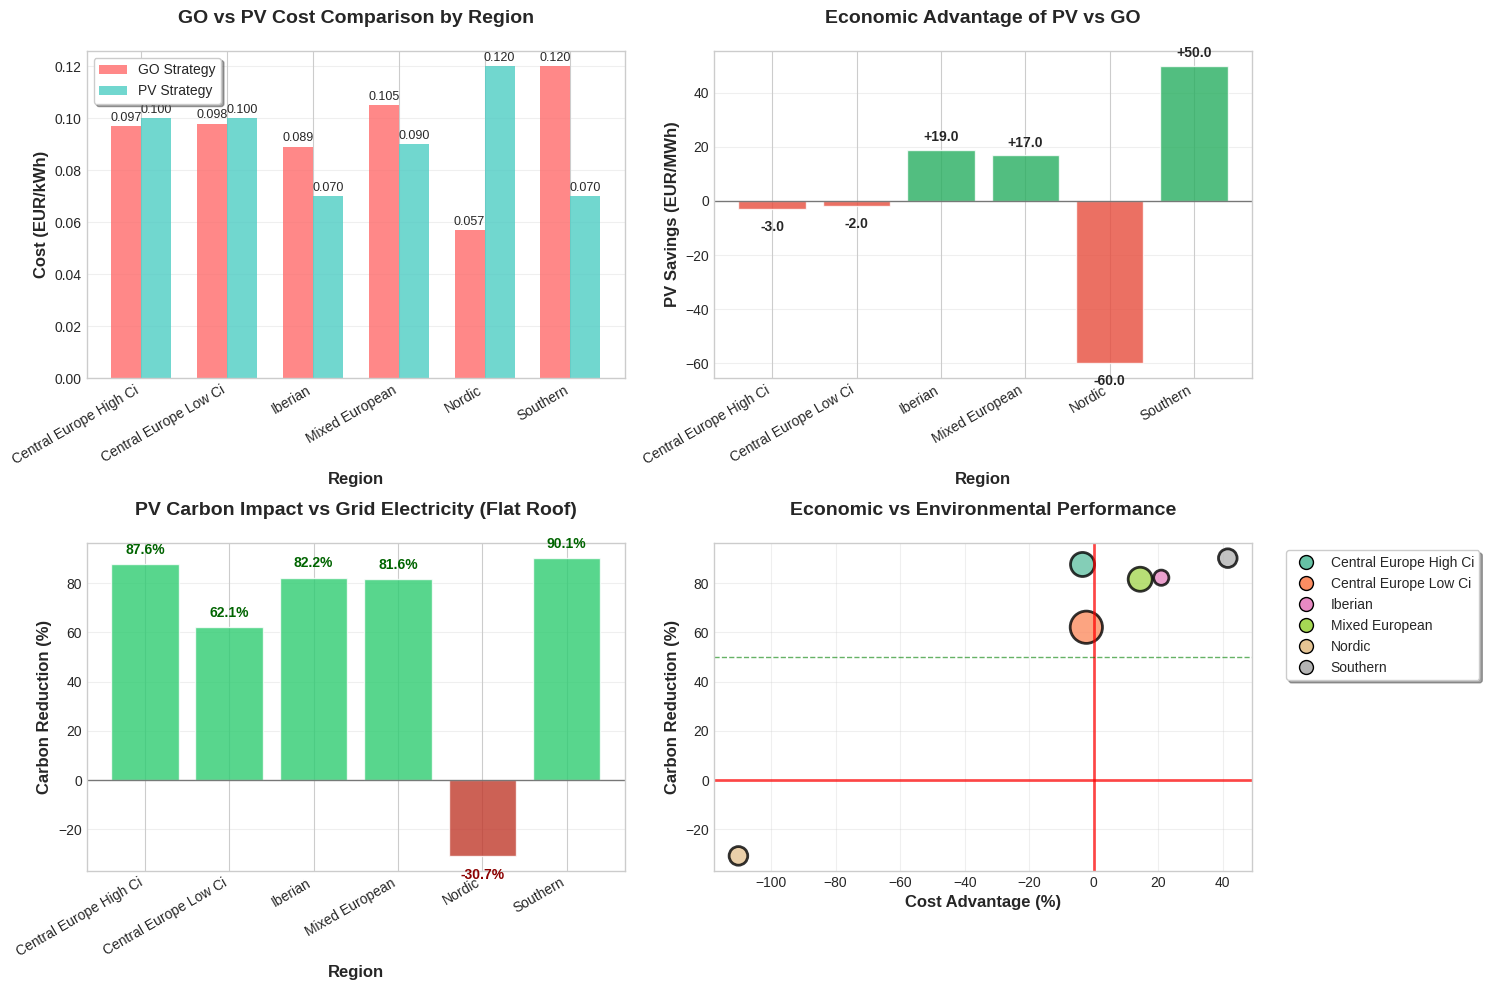

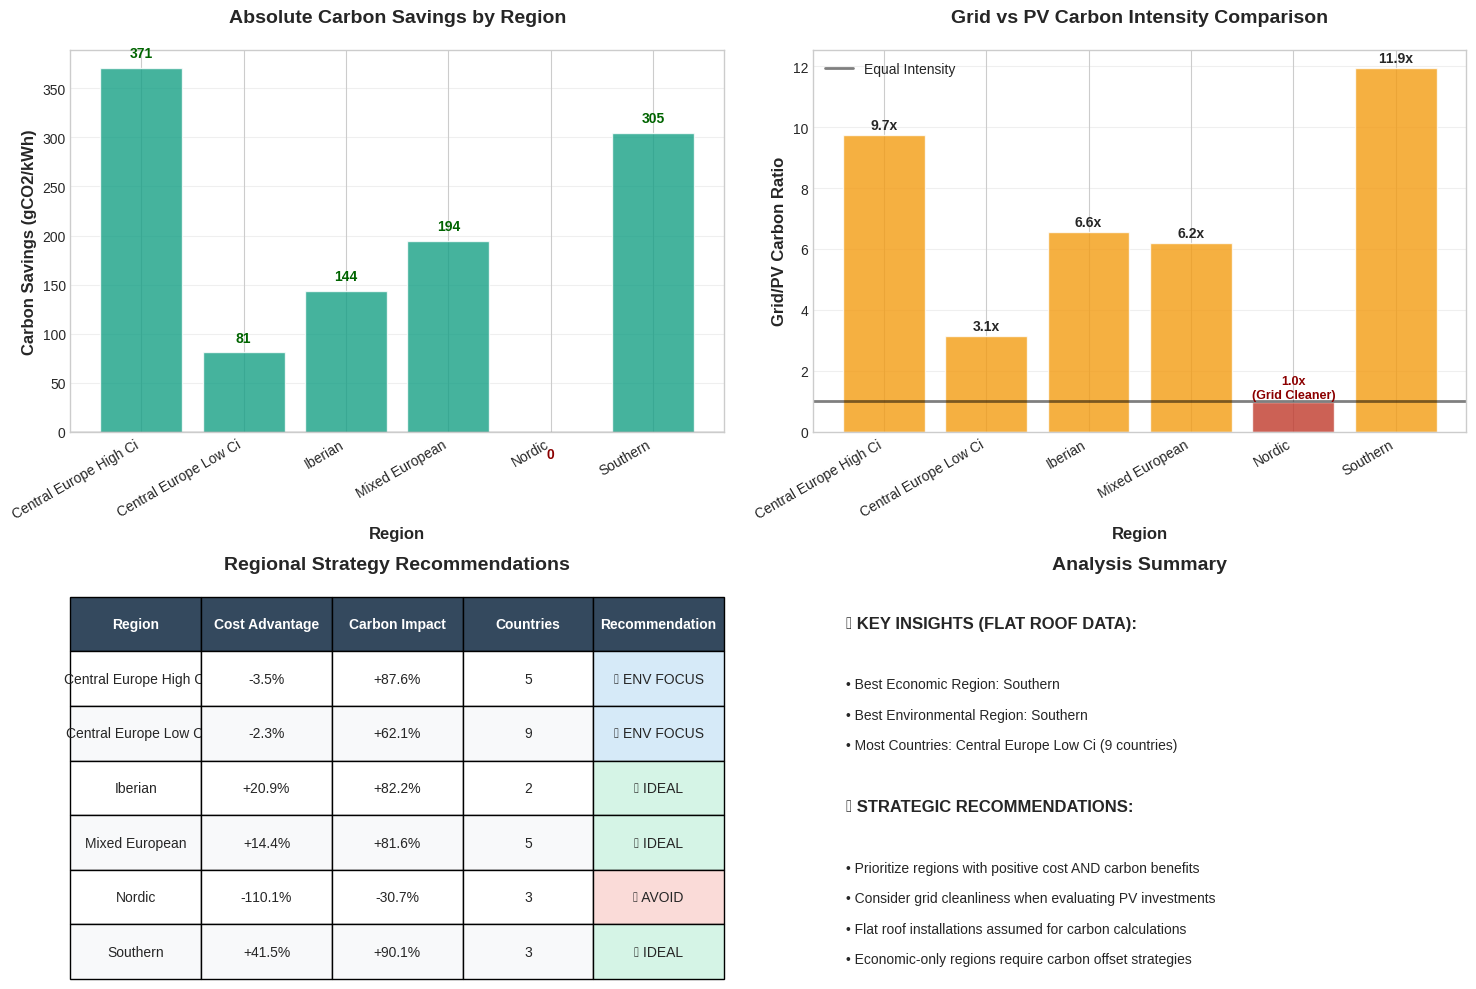

In [257]:
cluster_summary = create_go_pv_visualizations(df_with_variables, 2023)


🌡️  CREATING CLUSTER HEATMAP (FLAT ROOF DATA)


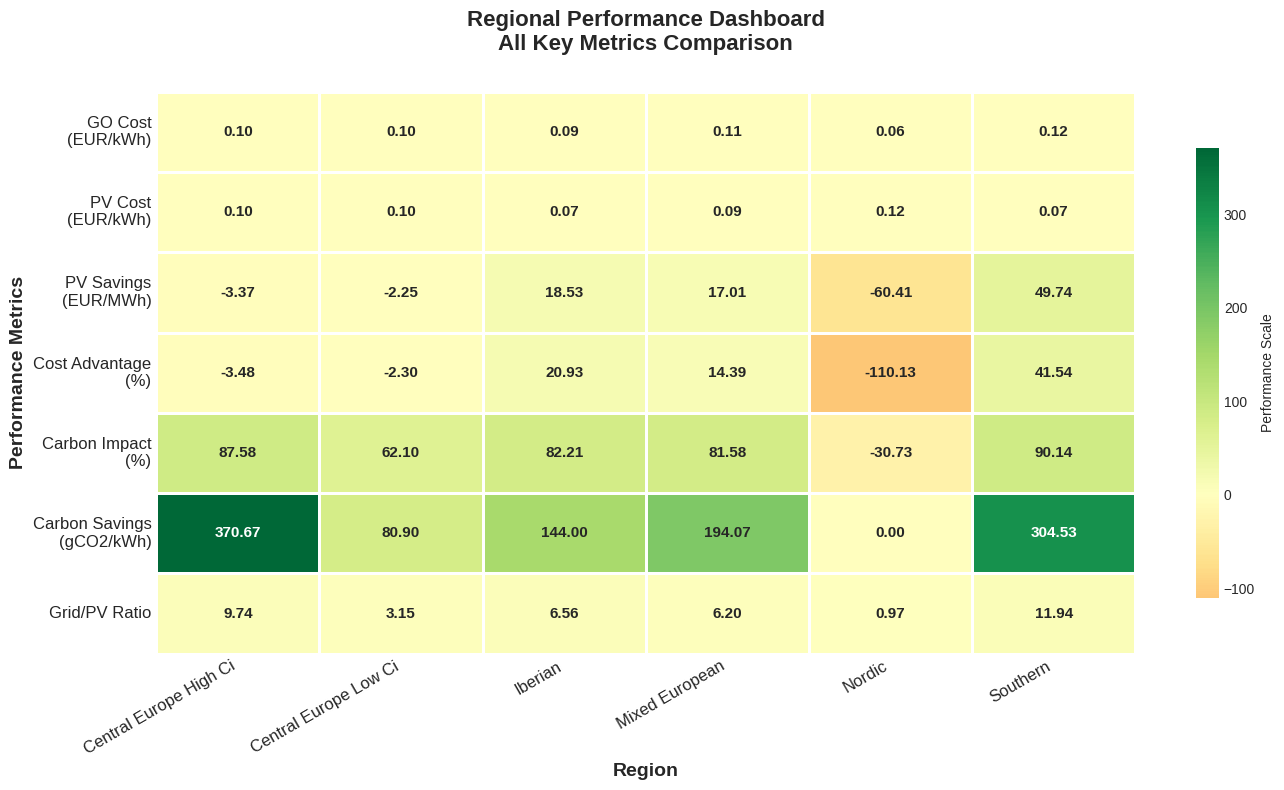

In [258]:
heatmap_data = create_summary_heatmap(df_with_variables, year)


🌍 CREATING COUNTRY-LEVEL SCATTER PLOT


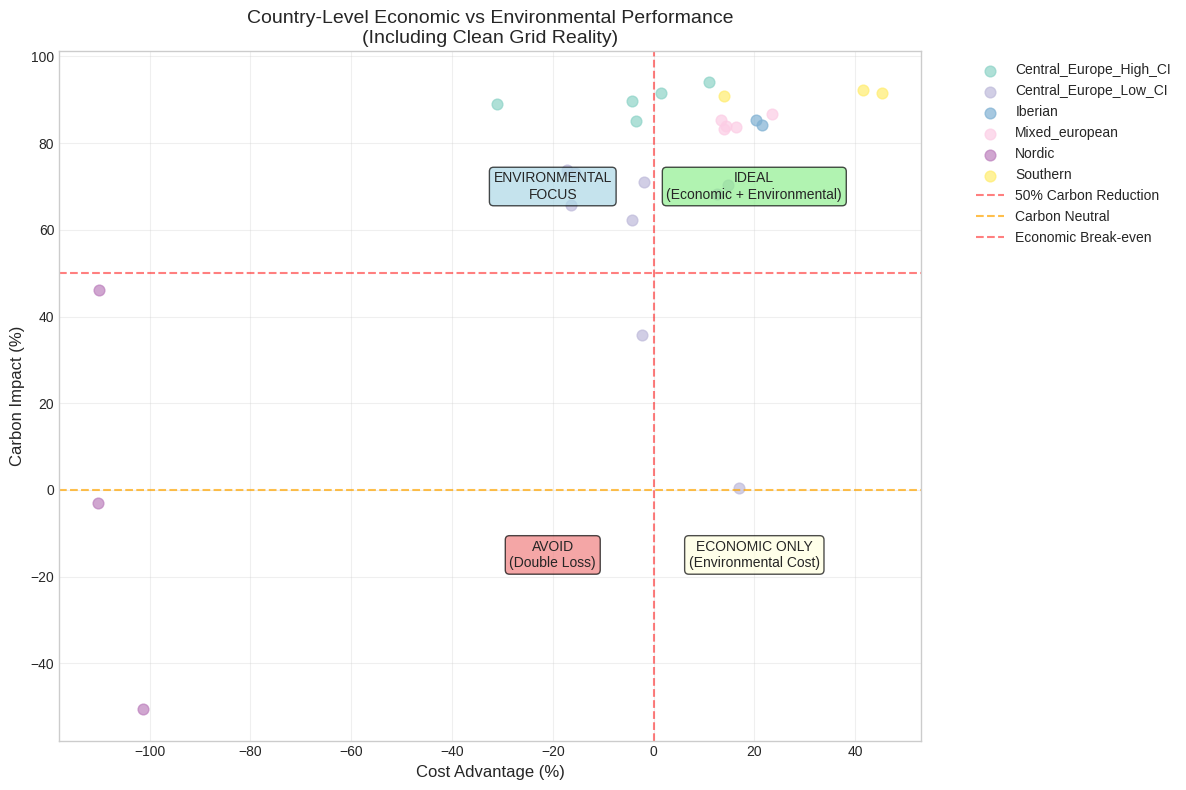

In [253]:
create_country_scatter(df_with_variables, 2023)

In [254]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_cluster_metrics(df, go_price_per_mwh=0.5):
    """
    Calculate requested metrics for each cluster
    """

    # Add cluster names if missing
    if 'Cluster_Name' not in df.columns:
        cluster_names = {0: "Nordic", 1: "Central_Western", 2: "Northern",
                        3: "Iberian", 4: "Southern", 5: "Mixed_European"}
        df['Cluster_Name'] = df['Cluster'].map(cluster_names)

    results = []

    for cluster_name in df['Cluster_Name'].unique():
        if pd.isna(cluster_name):
            continue

        cluster_data = df[df['Cluster_Name'] == cluster_name].copy()

        # 1. Price Volatility (2015-2023)
        all_prices = cluster_data[(cluster_data['Year'] >= 2015) & (cluster_data['Year'] <= 2023)]['Price (EUR/MWhe)']

        price_volatility = (all_prices.std() / all_prices.mean()) * 100  # Volatility = (σ/μ) * 100

        # 2. Decarbonization Slope (2015-2023)
        carbon_data = cluster_data[['Year', 'Carbon intensity of electricity - gCO2/kWh']].dropna()

        if len(carbon_data) >= 3:
            X = carbon_data['Year'].values.reshape(-1, 1)
            y = carbon_data['Carbon intensity of electricity - gCO2/kWh'].values
            model = LinearRegression().fit(X, y)

            decarb_slope_abs = model.coef_[0]  # gCO2/kWh per year
            baseline = carbon_data[carbon_data['Year'] == carbon_data['Year'].min()].iloc[0]['Carbon intensity of electricity - gCO2/kWh']
            decarb_slope_rel = (decarb_slope_abs / baseline * 100)  # % per year
        else:
            decarb_slope_abs = decarb_slope_rel = np.nan

        # 3. Cost Advantage Percentage (latest year)
        latest = cluster_data[cluster_data['Year'] == cluster_data['Year'].max()]

        if len(latest) > 0:
            elec_price_kwh = latest['Price (EUR/MWhe)'].median() / 1000
            go_total_cost_kwh = elec_price_kwh + (go_price_per_mwh / 1000)
            pv_cost_kwh = latest['Flat roof (gCO2-eq/kWh)'].median() / 1000  # Using Flat roof as requested

            corporate_savings = go_total_cost_kwh - pv_cost_kwh
            cost_advantage_pct = (corporate_savings / go_total_cost_kwh * 100)
        else:
            cost_advantage_pct = np.nan

        # 4. Carbon Effectiveness of PV
        if len(latest) > 0:
            grid_carbon = latest['Carbon intensity of electricity - gCO2/kWh'].median()
            pv_carbon = latest['Flat roof (gCO2-eq/kWh)'].median()  # Using Flat roof as requested
            carbon_effectiveness_pv = ((grid_carbon - pv_carbon) / grid_carbon * 100)
        else:
            carbon_effectiveness_pv = np.nan

        results.append({
            'Cluster_Name': cluster_name,
            'Price_Volatility (%)': price_volatility,
            'Decarb_Slope_Abs (gCO2/kWh/year)': decarb_slope_abs,
            'Decarb_Slope_Rel (%/year)': decarb_slope_rel,
            'Cost_Advantage (%)': cost_advantage_pct,
            'Carbon_Effectiveness (%)': carbon_effectiveness_pv
        })

    return pd.DataFrame(results).round(2)

# Usage:
# metrics = calculate_cluster_metrics(df, go_price_per_mwh=0.5)
# print(metrics)

In [259]:
metrics = calculate_cluster_metrics(df, go_price_per_mwh=0.5)
print(metrics)

             Cluster_Name  Price_Volatility (%)  \
0   Central_Europe_Low_CI                 89.36   
1                Southern                 83.29   
2  Central_Europe_High_CI                 82.43   
3                 Iberian                 58.58   
4                  Nordic                 70.66   
5          Mixed_european                 81.33   

   Decarb_Slope_Abs (gCO2/kWh/year)  Decarb_Slope_Rel (%/year)  \
0                             -8.67                      -5.04   
1                            -19.54                      -3.24   
2                            -21.46                      -3.88   
3                            -25.69                      -7.82   
4                             -4.63                      -2.55   
5                            -10.64                      -3.56   

   Cost_Advantage (%)  Carbon_Effectiveness (%)  
0               52.74                     60.44  
1               72.77                     90.28  
2               51.05        

##Risk analytics

###GOs

In [260]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class GOPriceSensitivityAnalysis:
    """
    GO Price Sensitivity Analysis for Corporate Scope 2 Strategy
    Analyzes how GO price changes affect strategy economics across clusters
    """

    def __init__(self, df, base_go_price=0.5):
        self.df = df.copy()
        self.base_go_price = base_go_price
        self.go_scenarios = [0.3, 0.5, 1, 3, 10]  # EUR/MWh
        self.analysis_year = self.df['Year'].max()
        self.setup_clusters()

    def setup_clusters(self):
        """Setup cluster mapping"""
        cluster_map = {
            0: "Nordic", 1: "Central_Western", 2: "Northern",
            3: "Iberian", 4: "Southern", 5: "Mixed_European"
        }
        if 'Cluster_Name' not in self.df.columns:
            self.df['Cluster_Name'] = self.df['Cluster'].map(cluster_map)
        self.clusters = self.df['Cluster_Name'].dropna().unique()

    def analyze_go_price_sensitivity(self):
        """
        Analyze how GO price changes affect strategy economics across clusters
        Returns switching points and cost advantages for each cluster
        """
        print("🏢 GO PRICE SENSITIVITY ANALYSIS")
        print("=" * 50)

        sensitivity_results = {}
        latest_data = self.df[self.df['Year'] == self.analysis_year].copy()

        for cluster_name in self.clusters:
            cluster_data = latest_data[latest_data['Cluster_Name'] == cluster_name]
            if len(cluster_data) == 0:
                continue

            # Base metrics
            base_elec_price = cluster_data['Price (EUR/MWhe)'].median() / 1000
            pv_cost = cluster_data['LCOE'].median()

            cluster_results = {
                'countries': cluster_data['Country'].tolist(),
                'base_electricity_price': base_elec_price,
                'pv_cost': pv_cost,
                'scenarios': {}
            }

            # Test each GO price scenario
            for go_price in self.go_scenarios:
                go_total_cost = base_elec_price + (go_price / 1000)
                savings_go_vs_pv = go_total_cost - pv_cost

                # Strategy determination
                if savings_go_vs_pv > 0.005:  # PV saves >5 EUR/MWh
                    strategy = "PV_PREFERRED"
                elif savings_go_vs_pv < -0.005:  # GO saves >5 EUR/MWh
                    strategy = "GO_PREFERRED"
                else:
                    strategy = "NEUTRAL"

                cluster_results['scenarios'][go_price] = {
                    'go_total_cost': go_total_cost,
                    'savings_eur_mwh': savings_go_vs_pv * 1000,
                    'strategy': strategy
                }

            # Find switching point
            cluster_results['switching_point'] = self.find_switching_point(cluster_results)
            sensitivity_results[cluster_name] = cluster_results

        self.display_results(sensitivity_results)
        return sensitivity_results

    def find_switching_point(self, cluster_results):
        """Find GO price where strategy switches from GO to PV preference"""
        scenarios = cluster_results['scenarios']
        sorted_prices = sorted(scenarios.keys())

        for i, price in enumerate(sorted_prices):
            if scenarios[price]['savings_eur_mwh'] > 5:  # PV becomes advantageous
                if i == 0:
                    return f"< €{price}/MWh"
                else:
                    prev_price = sorted_prices[i-1]
                    return f"€{prev_price}-{price}/MWh"
        return f"> €{sorted_prices[-1]}/MWh"

    def display_results(self, results):
        """Display GO sensitivity summary with all price scenarios"""
        print(f"{'Cluster':<15} {'Countries':<10} {'Base Elec':<12} {'PV Cost':<10} {'Switching Point':<15}")
        print("-" * 75)

        for cluster_name, data in results.items():
            countries = f"{len(data['countries'])} countries"
            base_elec = f"€{data['base_electricity_price']:.3f}/kWh"
            pv_cost = f"€{data['pv_cost']:.3f}/kWh"
            switching_point = data['switching_point']

            print(f"{cluster_name:<15} {countries:<10} {base_elec:<12} {pv_cost:<10} {switching_point:<15}")

        print("\n📊 Complete Strategy Analysis by GO Price:")
        print(f"{'Cluster':<15} {'€0.3/MWh':<18} {'€0.5/MWh':<18} {'€1/MWh':<18} {'€3/MWh':<18} {'€10/MWh':<18}")
        print("-" * 105)

        for cluster_name, data in results.items():
            scenarios = data['scenarios']

            def format_strategy(go_price):
                if go_price in scenarios:
                    strategy = scenarios[go_price]['strategy']
                    savings = scenarios[go_price]['savings_eur_mwh']
                    # Shorter format for better table fit
                    strategy_short = strategy.replace('_PREFERRED', '').replace('GO_', 'GO').replace('PV_', 'PV')
                    return f"{strategy_short} ({savings:+.0f})"
                return 'N/A'

            strategy_03 = format_strategy(0.3)
            strategy_05 = format_strategy(0.5)
            strategy_1 = format_strategy(1.0)
            strategy_3 = format_strategy(3.0)
            strategy_10 = format_strategy(10.0)

            print(f"{cluster_name:<15} {strategy_03:<18} {strategy_05:<18} {strategy_1:<18} {strategy_3:<18} {strategy_10:<18}")

        print("\n💡 Strategy Key:")
        print("- PV: PV_PREFERRED, GO: GO_PREFERRED, NEUTRAL: No clear preference")
        print("- Numbers in parentheses: EUR/MWh savings (positive = PV saves money)")
        print("- Switching Point: GO price where PV becomes economically preferred")

# Usage
def run_go_sensitivity_analysis(df):
    analyzer = GOPriceSensitivityAnalysis(df)
    results = analyzer.analyze_go_price_sensitivity()
    return analyzer, results

In [261]:
results1 = run_go_sensitivity_analysis(df)
print(results1)

🏢 GO PRICE SENSITIVITY ANALYSIS
Cluster         Countries  Base Elec    PV Cost    Switching Point
---------------------------------------------------------------------------
Central_Europe_Low_CI 9 countries €0.097/kWh   €0.100/kWh €3-10/MWh      
Southern        3 countries €0.119/kWh   €0.070/kWh < €0.3/MWh     
Central_Europe_High_CI 5 countries €0.096/kWh   €0.100/kWh €3-10/MWh      
Iberian         2 countries €0.088/kWh   €0.070/kWh < €0.3/MWh     
Nordic          3 countries €0.057/kWh   €0.120/kWh > €10/MWh      
Mixed_european  5 countries €0.105/kWh   €0.090/kWh < €0.3/MWh     

📊 Complete Strategy Analysis by GO Price:
Cluster         €0.3/MWh           €0.5/MWh           €1/MWh             €3/MWh             €10/MWh           
---------------------------------------------------------------------------------------------------------
Central_Europe_Low_CI NEUTRAL (-2)       NEUTRAL (-2)       NEUTRAL (-2)       NEUTRAL (+0)       PV (+7)           
Southern        PV (+50)   

###Price

####Price resilience to crisis

In [262]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class ElectricityPriceVolatilityRiskAnalysis:
    """
    Electricity Price Volatility Risk Analysis for Corporate Scope 2 Strategy
    Analyzes price volatility and its impact on strategy risk for risk-averse corporations
    """

    def __init__(self, df, base_go_price=0.5):
        self.df = df.copy()
        self.base_go_price = base_go_price
        self.analysis_year = self.df['Year'].max()
        self.setup_clusters()

    def setup_clusters(self):
        """Setup cluster mapping"""
        cluster_map = {
            0: "Nordic", 1: "Central_Western", 2: "Northern",
            3: "Iberian", 4: "Southern", 5: "Mixed_European"
        }
        if 'Cluster_Name' not in self.df.columns:
            self.df['Cluster_Name'] = self.df['Cluster'].map(cluster_map)
        self.clusters = self.df['Cluster_Name'].dropna().unique()

    def analyze_price_volatility_risk(self):
        """
        Analyze electricity price volatility and its impact on strategy risk
        Focus: Risk-averse corporate preference for predictable costs
        Calculate CV for 3 different time frames
        """
        print("⚡ ELECTRICITY MARKET CRISIS RESILIENCE ANALYSIS")
        print("=" * 55)

        volatility_results = {}

        # Define 3 periods for analysis
        pre_crisis_period = self.df[self.df['Year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]  # Normal period
        crisis_period = self.df[self.df['Year'].isin([2021, 2022, 2023])]  # Crisis/Stress period
        overall_period = self.df[self.df['Year'].isin([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])]  # Full period

        for cluster_name in self.clusters:
            cluster_pre_crisis = pre_crisis_period[pre_crisis_period['Cluster_Name'] == cluster_name]
            cluster_crisis = crisis_period[crisis_period['Cluster_Name'] == cluster_name]
            cluster_overall = overall_period[overall_period['Cluster_Name'] == cluster_name]

            if len(cluster_pre_crisis) == 0 or len(cluster_crisis) == 0 or len(cluster_overall) == 0:
                continue

            # Calculate volatility metrics for each time frame
            pre_crisis_prices = cluster_pre_crisis['Price (EUR/MWhe)']
            crisis_prices = cluster_crisis['Price (EUR/MWhe)']
            overall_prices = cluster_overall['Price (EUR/MWhe)']

            # Calculate CV for each time frame
            cv_pre_crisis = (pre_crisis_prices.std() / pre_crisis_prices.mean()) * 100
            cv_crisis = (crisis_prices.std() / crisis_prices.mean()) * 100
            cv_overall = (overall_prices.std() / overall_prices.mean()) * 100

            # Additional metrics
            var_95 = np.percentile(overall_prices, 95)  # 95th percentile (stress scenario)
            pre_crisis_median = pre_crisis_prices.median()
            crisis_median = crisis_prices.median()
            stress_multiple = var_95 / pre_crisis_median

            # Strategy risk analysis
            latest_cluster_data = cluster_crisis[cluster_crisis['Year'] == self.analysis_year]
            pv_cost = latest_cluster_data['LCOE'].median() * 1000 if not latest_cluster_data.empty else np.nan

            # GO strategy risk (exposed to price volatility)
            go_cost_normal = pre_crisis_median + self.base_go_price
            go_cost_stress = var_95 + self.base_go_price
            go_risk_exposure = go_cost_stress - go_cost_normal

            # RESILIENCE METRICS - Focus on crisis response
            volatility_multiplier = cv_crisis / cv_pre_crisis  # How much volatility increased
            price_shock_ratio = crisis_median / pre_crisis_median  # Price level increase

            # Resilience scoring (lower is more resilient)
            # Combine volatility increase and price shock
            resilience_score = (volatility_multiplier * 0.6) + (price_shock_ratio * 0.4)

            # Resilience classification
            if resilience_score < 2.0:
                resilience_level = "HIGH_RESILIENCE"
            elif resilience_score < 3.0:
                resilience_level = "MEDIUM_RESILIENCE"
            else:
                resilience_level = "LOW_RESILIENCE"

            # Risk classification based on CRISIS CV only (more relevant)
            if cv_crisis > 50:
                volatility_risk = "HIGH"
                risk_preference = "PV_PREFERRED"
            elif cv_crisis > 35:
                volatility_risk = "MEDIUM"
                risk_preference = "PV_SLIGHT_PREFERENCE"
            else:
                volatility_risk = "LOW"
                risk_preference = "NEUTRAL"

            # Volatility trend analysis
            if volatility_multiplier > 2.0:
                volatility_trend = "SEVERE_INCREASE"
            elif volatility_multiplier > 1.5:
                volatility_trend = "MODERATE_INCREASE"
            else:
                volatility_trend = "STABLE"

            volatility_results[cluster_name] = {
                'cv_pre_crisis': cv_pre_crisis,
                'cv_crisis': cv_crisis,
                'volatility_multiplier': volatility_multiplier,
                'price_shock_ratio': price_shock_ratio,
                'resilience_score': resilience_score,
                'resilience_level': resilience_level,
                'volatility_trend': volatility_trend,
                'pre_crisis_price_median': pre_crisis_median,
                'crisis_price_median': crisis_median,
                'stress_price_95th': var_95,
                'volatility_risk_level': volatility_risk,
                'risk_adjusted_preference': risk_preference,
                'countries': cluster_crisis['Country'].unique().tolist()
            }

        self.display_results(volatility_results)
        return volatility_results

    def display_results(self, results):
        """Display price volatility risk results focused on crisis resilience"""
        print(f"{'Cluster':<15} {'Pre-Crisis':<11} {'Crisis CV':<10} {'Vol Mult':<9} {'Price Shock':<11} {'Resilience':<15}")
        print("-" * 85)

        # Sort by resilience score (best to worst)
        sorted_results = sorted(results.items(), key=lambda x: x[1]['resilience_score'])

        for cluster_name, data in sorted_results:
            cv_pre = f"{data['cv_pre_crisis']:.0f}%"
            cv_crisis = f"{data['cv_crisis']:.0f}%"
            vol_mult = f"{data['volatility_multiplier']:.1f}x"
            price_shock = f"{data['price_shock_ratio']:.1f}x"
            resilience = data['resilience_level']

            print(f"{cluster_name:<15} {cv_pre:<11} {cv_crisis:<10} {vol_mult:<9} {price_shock:<11} {resilience:<15}")

        print(f"\nRESILIENCE RANKING (Best to Worst):")
        for i, (cluster_name, data) in enumerate(sorted_results, 1):
            score = data['resilience_score']
            print(f"{i}. {cluster_name}: {score:.2f} ({data['resilience_level']})")

        print(f"\nResilience Metrics Explained:")
        print(f"- Vol Mult: How much volatility increased (Crisis CV ÷ Pre-Crisis CV)")
        print(f"- Price Shock: How much prices increased (Crisis Price ÷ Pre-Crisis Price)")
        print(f"- Resilience Score: Combined metric (lower = more resilient)")

        print(f"\nResilience Levels:")
        print(f"- HIGH_RESILIENCE: Score < 2.0")
        print(f"- MEDIUM_RESILIENCE: Score 2.0-3.0")
        print(f"- LOW_RESILIENCE: Score > 3.0")

# Usage
def run_volatility_risk_analysis(df):
    analyzer = ElectricityPriceVolatilityRiskAnalysis(df)
    results = analyzer.analyze_price_volatility_risk()
    return analyzer, results

In [263]:
results2 = run_volatility_risk_analysis(df)
print(results2)


⚡ ELECTRICITY MARKET CRISIS RESILIENCE ANALYSIS
Cluster         Pre-Crisis  Crisis CV  Vol Mult  Price Shock Resilience     
-------------------------------------------------------------------------------------
Nordic          32%         46%        1.4x      2.1x        HIGH_RESILIENCE
Iberian         18%         30%        1.7x      2.3x        HIGH_RESILIENCE
Mixed_european  19%         45%        2.4x      2.4x        MEDIUM_RESILIENCE
Central_Europe_High_CI 18%         45%        2.4x      2.8x        MEDIUM_RESILIENCE
Southern        18%         48%        2.7x      2.6x        MEDIUM_RESILIENCE
Central_Europe_Low_CI 18%         49%        2.7x      2.8x        MEDIUM_RESILIENCE

RESILIENCE RANKING (Best to Worst):
1. Nordic: 1.70 (HIGH_RESILIENCE)
2. Iberian: 1.93 (HIGH_RESILIENCE)
3. Mixed_european: 2.40 (MEDIUM_RESILIENCE)
4. Central_Europe_High_CI: 2.57 (MEDIUM_RESILIENCE)
5. Southern: 2.69 (MEDIUM_RESILIENCE)
6. Central_Europe_Low_CI: 2.72 (MEDIUM_RESILIENCE)

Resilience Met

###Ols

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class SimpleOLSAnalysis:
    """
    Simplified OLS analysis for grid decarbonization risk
    """

    def __init__(self, df):
        self.df = df.copy()
        self.setup_clusters()

    def setup_clusters(self):
        cluster_map = {0: "Nordic", 1: "Central_Western", 2: "Northern",
                      3: "Iberian", 4: "Southern", 5: "Mixed_European"}
        if 'Cluster_Name' not in self.df.columns:
            self.df['Cluster_Name'] = self.df['Cluster'].map(cluster_map)
        self.clusters = self.df['Cluster_Name'].dropna().unique()

    def run_analysis(self):
        """Run simplified OLS analysis"""
        print("🔬 SIMPLIFIED OLS ANALYSIS")
        print("=" * 50)

        results = {}
        for cluster_name in self.clusters:
            cluster_data = self.df[self.df['Cluster_Name'] == cluster_name]
            if len(cluster_data) == 0:
                continue

            result = self.run_regression(cluster_data)
            if result:
                results[cluster_name] = result

        self.display_results(results)
        return results

    def run_regression(self, cluster_data):
        """Run single regression for cluster"""
        # Prepare annual data (only time-varying variables)
        annual_data = cluster_data.groupby('Year').agg({
            'Carbon intensity of electricity - gCO2/kWh': 'median'
        }).reset_index()

        if len(annual_data) < 6:
            return None

        # Create time-varying variables only
        annual_data['time_trend'] = annual_data['Year'] - annual_data['Year'].min()
        annual_data['green_deal'] = (annual_data['Year'] >= 2019).astype(int)
        annual_data['policy_time'] = annual_data['time_trend'] * annual_data['green_deal']

        # Set up regression (no PV controls since they're cluster constants)
        y = annual_data['Carbon intensity of electricity - gCO2/kWh'].values
        X = np.column_stack([
            np.ones(len(annual_data)),  # constant (absorbs cluster-level PV effects)
            annual_data['time_trend'].values,
            annual_data['green_deal'].values,
            annual_data['policy_time'].values
        ])

        try:
            # OLS: β = (X'X)^(-1)X'y
            beta = np.linalg.inv(X.T @ X) @ X.T @ y
            residuals = y - X @ beta
            mse = np.sum(residuals**2) / (len(y) - X.shape[1])
            se_beta = np.sqrt(mse * np.diag(np.linalg.inv(X.T @ X)))
            t_stats = beta / se_beta
            p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), len(y) - X.shape[1]))
            r_squared = 1 - np.sum(residuals**2) / np.sum((y - np.mean(y))**2)

            # Get cluster PV characteristics for reference
            pv_ci = cluster_data['S-opta (gCO2-eq/kWh)'].median()
            pv_lcoe = cluster_data['LCOE'].median()

            return {
                'coefficients': beta,
                'se': se_beta,
                'p_values': p_values,
                'r_squared': r_squared,
                'pv_ci': pv_ci,
                'pv_lcoe': pv_lcoe
            }
        except:
            return None

    def display_results(self, results):
        """Display results in econometric format"""
        print(f"\n📊 Regression Results (Dependent Variable: Grid Carbon Intensity)")
        print("-" * 70)
        print(f"{'Cluster':<15} {'Constant':<12} {'Time Trend':<12} {'Green Deal':<12} {'Policy×Time':<12} {'R²':<8}")
        print("-" * 70)

        for cluster_name, data in results.items():
            coefs = data['coefficients']
            ses = data['se']
            pvals = data['p_values']

            # Format with significance stars
            constant = self.format_coef(coefs[0], pvals[0])
            time_coef = self.format_coef(coefs[1], pvals[1])
            green_coef = self.format_coef(coefs[2], pvals[2])
            policy_coef = self.format_coef(coefs[3], pvals[3])
            r_sq = f"{data['r_squared']:.3f}"

            print(f"{cluster_name:<15} {constant:<12} {time_coef:<12} {green_coef:<12} {policy_coef:<12} {r_sq:<8}")

            # Standard errors
            se_row = f"{'':15} ({ses[0]:.2f})     ({ses[1]:.2f})     ({ses[2]:.2f})     ({ses[3]:.2f})     "
            print(se_row)
            print()

        print("Significance: *** p<0.01, ** p<0.05, * p<0.10")
        print("Standard errors in parentheses")

        # Show PV characteristics by cluster
        print(f"\n📊 Cluster PV Characteristics (Time-Invariant):")
        print(f"{'Cluster':<15} {'PV CI (gCO2/kWh)':<18} {'PV LCOE (EUR/kWh)':<18}")
        print("-" * 55)
        for cluster_name, data in results.items():
            pv_ci = f"{data['pv_ci']:.1f}"
            pv_lcoe = f"{data['pv_lcoe']:.3f}"
            print(f"{cluster_name:<15} {pv_ci:<18} {pv_lcoe:<18}")

        # Show equation
        print(f"\n📝 Equation (Cluster-Specific):")
        print("Grid_CI_t = β₀ + β₁(Time_t) + β₂(Green_Deal_t) + β₃(Policy×Time_t) + ε_t")
        print("\nNote: PV characteristics are cluster constants absorbed in β₀")

    def format_coef(self, coef, p_val):
        """Format coefficient with significance stars"""
        if p_val < 0.01:
            stars = "***"
        elif p_val < 0.05:
            stars = "**"
        elif p_val < 0.10:
            stars = "*"
        else:
            stars = ""
        return f"{coef:.3f}{stars}"

# Usage
def run_simple_ols(df):
    analyzer = SimpleOLSAnalysis(df)
    results = analyzer.run_analysis()
    return analyzer, results

In [ ]:
result = run_enhanced_ols_analysis(df)
print(result)


🔬 ADVANCED OLS RISK ANALYSIS

📊 Analyzing Central_Western Cluster:
----------------------------------------

📊 Analyzing Northern Cluster:
----------------------------------------

📊 Analyzing Southern Cluster:
----------------------------------------

📊 Analyzing Iberian Cluster:
----------------------------------------

📊 Analyzing Nordic Cluster:
----------------------------------------

📊 Analyzing Mixed_European Cluster:
----------------------------------------

🔬 COMPREHENSIVE OLS RISK ANALYSIS RESULTS

📊 Multiple Regression Results (Dependent Variable: Grid Carbon Intensity):
------------------------------------------------------------------------------------------
Cluster         Constant     Time Trend   Green Deal   Policy×Time  PV CI      PV LCOE    R²      
------------------------------------------------------------------------------------------
Central_Western -142.140     0.643        37.810       -11.529      4.655      -345.285*** -78.078 
                (8518967229.8

In [ ]:
result = run_simple_ols(df)
print(result)

🔬 SIMPLIFIED OLS ANALYSIS

📊 Regression Results (Dependent Variable: Grid Carbon Intensity)
----------------------------------------------------------------------
Cluster         Constant     Time Trend   Green Deal   Policy×Time  R²      
----------------------------------------------------------------------
Central_Western 168.312***   0.643        37.810       -11.529      0.833   
                (9.17)     (4.90)     (23.26)     (6.01)     

Northern        530.347***   -23.445**    -87.790*     10.378       0.962   
                (15.32)     (8.19)     (38.85)     (10.03)     

Southern        500.379***   -12.952      -16.088      -5.256       0.959   
                (13.16)     (7.03)     (33.37)     (8.62)     

Iberian         358.374***   -7.119       -14.058      -13.906      0.904   
                (25.02)     (13.37)     (63.44)     (16.38)     

Nordic          41.501***    0.511        -0.027       -0.604       0.374   
                (1.13)     (0.60)     (2.86)  